# MODELAGEM DE SCORE DE CRÉDITO: PREVISÃO DE INADIMPLÊNCIA

## Objetivo

O presente projeto visa prever a probabilidade de um cliente recorrente ser inadimplente em um novo pedido de crédito.

## Descrição do problema

A empresa **Digibank** tem tido sérios problemas com inadimplência na disponibilização de crédito aos seus clientes. A fim de evitar perdas significativas nesse serviço, a Digibank solicitou ao time Datarisk o desenvolvimento de um modelo preditivo capaz calcular a probabilidade de um cliente ser inadimplente em um novo pedido de crédito.

Para a resolução do problema foram disponibilizadas **3 bases de dados**, sendo elas:
1. **Base Cadastral:** contém informações estáticas dos clientes. Possui 8 features.<br>

| Variável | Descrição |
| :---: | :---: |
| ID_CLIENTE | Identificador único do cliente |
| DATA_CADASTRO | Data da realização do cadastro no sistema |
| DDD | Número do DDD do telefone do cliente |
| FLAG_PF | Indica se o cliente é uma pessoa física (‘X’) ou jurídica (‘NaN’) |
| SEGMENTO_INDUSTRIAL | Indica a qual segmento da indústria pertence o cliente |
| DOMINIO_EMAIL | Indica o domínio(ou provedor) do email utilizado para o cadastro |
| PORTE | Indica o porte (tamanho) da empresa |
| CEP_2_DIG | Indica os dois primeiros números do CEP do endereço cadastrado |

2. **Base Info:** contém informações adicionais dos clientes. Os dados variam mensalmente para cada cliente.

| Variável | Descrição |
| :---: | :---: |
| ID_CLIENTE | Identificador único do cliente |
| SAFRA_REF | Mês de referência da amostra |
| RENDA_MES_ANTERIOR | Renda ou faturamento declarado pelo cliente no fim do mês anterior |
| NO_FUNCIONARIOS | Número de funcionários reportado pelo cliente no fim do mês anterior |

3. **Base Pagamentos:** possui todas as transações passadas de empréstimos dos clientes.

| Variável | Descrição |
| :---: | :---: |
| ID_CLIENTE | Identificador único do cliente |
| SAFRA_REF | Mês de referência da amostra |
| DATA_EMISSAO_DOCUMENTO | Data da emissão da nota de crédito |
| DATA_VENCIMENTO | Data limite para pagamento do empréstimo |
| VALOR_A_PAGAR | Valor da nota de crédito |
| TAXA | Taxa de juros cobrada no empréstimo |
| DATA_PAGAMENTO | Data em que o cliente realizou o pagamento da nota(disponível apenas na base de desenvolvimento) |

4. **Variável Resposta:** É a inadimplência do cliente em cada transação. Serão consideradas **inadimplentes** as transações que possuírem uma diferença entre as datas de pagamento e vencimento maior ou igual a **5 dias**.

## Entregas do projeto

Deploy do modelo via API de modo que usuário consiga realizar predições através de requisições na API.

# 0 - IMPORTS, HELPER FUNCTIONS E CARREGAMENTO DOS DADOS

## 0.1 - IMPORTS

In [209]:
import time
import pickle
import warnings
import pandas                        as pd
import numpy                         as np

import matplotlib.pyplot             as plt
import seaborn                       as sns
from scikitplot                      import metrics                   as mt

from scipy                           import stats                     as ss

from sklearn                         import preprocessing             as pp
from sklearn.model_selection         import train_test_split, StratifiedKFold, GridSearchCV
from sklearn                         import ensemble                  as en
from sklearn.linear_model            import LogisticRegression
from sklearn.metrics                 import roc_auc_score, precision_score, recall_score

import xgboost                       as xgb
import lightgbm                      as lgb

from imblearn.under_sampling         import RandomUnderSampler

## 0.2 - Helper functions

Funções de ajuda que serão chamadas durante o desenvolvimento do problema.

In [210]:
# Funçaõ de Cramer
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k =  cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

# Filtro de warnings
warnings.filterwarnings('ignore')

# Supressão de notação científica
pd.options.display.float_format = '{:.3f}'.format

## 0.3 - Carregamento dos dados

### 0.3.1 - Loading

In [211]:
# base_cadastral
df_bc = pd.read_csv('dataset/base_cadastral.csv')

# base_info
df_bi = pd.read_csv('dataset/base_info.csv')

# base_pagamentos_desenvolvimento
df_bpd = pd.read_csv('dataset/base_pagamentos_desenvolvimento.csv')

# base_pagamentos_teste
df_bpt = pd.read_csv('dataset/base_pagamentos_teste.csv')

### 0.3.2 - Merge dos datasets

In [212]:
# Merge df_raw e base_cadastral
df_raw = pd.merge(df_bpd, df_bc, how='left', on='ID_CLIENTE')

# Merge df_raw e base_info
df_raw = pd.merge(df_raw, df_bi, how='left', on=['ID_CLIENTE', 'SAFRA_REF'])

### 0.3.3 - Criação da variável resposta

In [213]:
# to_datetime
df_raw['DATA_PAGAMENTO'] = pd.to_datetime(df_raw['DATA_PAGAMENTO'])
df_raw['DATA_VENCIMENTO'] = pd.to_datetime(df_raw['DATA_VENCIMENTO'])

# Definição da variável resposta
df_raw['INADIMPLENTE'] = df_raw.loc[:, ['DATA_PAGAMENTO', 'DATA_VENCIMENTO']]\
                               .apply(lambda x: 1 if np.timedelta64((x['DATA_PAGAMENTO'] - x['DATA_VENCIMENTO']), 'D')  >= 5 else 
                                                0, axis=1)

### 0.3.4 - Nomes das features em snakecase

In [214]:
df_raw.columns = [x.lower() for x in list(df_raw.columns)]

# 1 - DESCRIÇÃO DOS DADOS

In [215]:
df1 = df_raw.copy()

## 1.1 - Dimensão dos dados

In [216]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 77414
Número de colunas: 17


## 1.2 - Checagem e transformação de data types

In [217]:
df1.dtypes

id_cliente                         int64
safra_ref                         object
data_emissao_documento            object
data_pagamento            datetime64[ns]
data_vencimento           datetime64[ns]
valor_a_pagar                    float64
taxa                             float64
data_cadastro                     object
ddd                               object
flag_pf                           object
segmento_industrial               object
dominio_email                     object
porte                             object
cep_2_dig                         object
renda_mes_anterior               float64
no_funcionarios                  float64
inadimplente                       int64
dtype: object

In [218]:
# Transformação dos dtypes
to_object_dict = {'id_cliente': 'str', 
                  'data_emissao_documento': 'datetime64[ns]', 
                  'data_cadastro': 'datetime64[ns]'}
df1 = df1.astype(to_object_dict)

In [219]:
df1.dtypes

id_cliente                        object
safra_ref                         object
data_emissao_documento    datetime64[ns]
data_pagamento            datetime64[ns]
data_vencimento           datetime64[ns]
valor_a_pagar                    float64
taxa                             float64
data_cadastro             datetime64[ns]
ddd                               object
flag_pf                           object
segmento_industrial               object
dominio_email                     object
porte                             object
cep_2_dig                         object
renda_mes_anterior               float64
no_funcionarios                  float64
inadimplente                       int64
dtype: object

## 1.3 - Checagem e substituição de NAs

In [220]:
df1.isna().sum()

id_cliente                    0
safra_ref                     0
data_emissao_documento        0
data_pagamento                0
data_vencimento               0
valor_a_pagar                 0
taxa                          0
data_cadastro                 0
ddd                        7414
flag_pf                   77195
segmento_industrial        1417
dominio_email               898
porte                      2476
cep_2_dig                     0
renda_mes_anterior         3937
no_funcionarios            3937
inadimplente                  0
dtype: int64

### 1.3.1 - Preenchendo os NAs

#### ddd

Os dados faltantes serão preenchidos com o valor de 'ddd' mais frequente para cada valor da feature 'cep_2_dig' (variável escolhida como referência por não conter nenhum valor nulo). Os valores de 'ddd' fora do padrão de 2 dígitos não serão modificados, pois não é possível identificar o segundo dígito.

In [221]:
df1['ddd'].unique()

array(['99', '31', '75', '49', '88', '18', '67', '21', '11', '44', nan,
       '19', '14', '16', '85', '41', '51', '12', '62', '43', '91', '42',
       '61', '33', '48', '71', '65', '38', '24', '(3', '47', '28', '(2',
       '81', '35', '13', '86', '94', '45', '17', '55', '64', '69', '32',
       '(6', '27', '66', '63', '46', '(1', '54', '77', '34', '74', '37',
       '53', '56', '95', '22', '73', '(9', '(4', '52', '87', '98', '(8',
       '92', '82', '79', '93', '83', '00', '(5', '15', '02', '84', '(0',
       '04', '07'], dtype=object)

In [222]:
# Groupby
aux = df1.loc[df1['ddd'].notnull(), ['ddd', 'cep_2_dig']].groupby(['cep_2_dig', 'ddd']).size().reset_index()
aux = aux.rename(columns={0: 'contagem_ddd'})

# Manter apenas os maiores valores de contagem_ddd por valor de 'cep_2_dig'
aux = aux.sort_values(['cep_2_dig', 'contagem_ddd'], ascending=(True, False))
aux = aux.drop_duplicates('cep_2_dig', keep='first')
aux = aux.rename(columns={'ddd': 'ddd_subs'})

# Merge com o dataset principal
df1 = pd.merge(df1, aux.loc[:, ['cep_2_dig', 'ddd_subs']], how='left', on='cep_2_dig')

# Preenchimentos dos NAs
df1['ddd'] = df1.loc[:, ['ddd', 'ddd_subs']].apply(lambda x: x['ddd_subs'] if pd.isnull(x['ddd']) else x['ddd'], axis=1)

# Preenchimento dos NAs que sobraram (8 linhas) com o ddd mais comum em todo o dataset
ddd_mais_comum = aux.sort_values('contagem_ddd', ascending=False)
ddd_mais_comum = ddd_mais_comum.iloc[0, 1]
df1['ddd'].fillna(ddd_mais_comum, inplace=True)

# Drop columns
df1 = df1.drop('ddd_subs', axis=1)

#### flag_pf

Como dito na seção **Descrição do problema**, os valores nulos devem ser considerados 'PJ'. Valores não nulos, 'PF'.

In [223]:
df1['flag_pf'] = df1.loc[:, 'flag_pf'].apply(lambda x: 'PF' if pd.notnull(x) else 'PJ')

#### segmento_industrial

Os dados faltantes serão substituídos pelo valor mais frequente de 'segmento_industrial' para cada valor único de 'cep_2_dig'.

In [224]:
# Groupby
aux = df1.loc[df1['segmento_industrial'].notnull(), ['segmento_industrial', 'cep_2_dig']].groupby(['cep_2_dig', 'segmento_industrial']).size().reset_index()
aux = aux.rename(columns={0: 'contagem_segmento_industrial'})

# Manter apenas os maiores valores de contagem_segmento_industrial por valor de 'cep_2_dig'
aux = aux.sort_values(['cep_2_dig', 'contagem_segmento_industrial'], ascending=(True, False))
aux = aux.drop_duplicates('cep_2_dig', keep='first')
aux = aux.rename(columns={'segmento_industrial': 'segmento_industrial_subs'})

# Merge com o dataset principal
df1 = pd.merge(df1, aux.loc[:, ['cep_2_dig', 'segmento_industrial_subs']], how='left', on='cep_2_dig')

# Preenchimentos dos NAs
df1['segmento_industrial'] = df1.loc[:, ['segmento_industrial', 'segmento_industrial_subs']]\
                                .apply(lambda x: x['segmento_industrial_subs'] if pd.isnull(x['segmento_industrial']) else x['segmento_industrial'], axis=1)

# Drop columns
df1 = df1.drop('segmento_industrial_subs', axis=1)

#### dominio_email

Os dados faltantes serão substituídos pelo valor mais frequente de 'dominio_email' para cada valor único de 'cep_2_dig'.

In [225]:
# groupby
aux = df1.loc[df1['dominio_email'].notnull(), ['dominio_email', 'cep_2_dig']].groupby(['cep_2_dig', 'dominio_email']).size().reset_index()
aux = aux.rename(columns={0: 'contagem_dominio_email'})

# Manter apenas os maiores valores de contagem_dominio_email por valor de 'cep_2_dig'
aux = aux.sort_values(['cep_2_dig', 'contagem_dominio_email'], ascending=(True, False))
aux = aux.drop_duplicates('cep_2_dig', keep='first')
aux = aux.rename(columns={'dominio_email': 'dominio_email_subs'})

# Merge com o dataset principal
df1 = pd.merge(df1, aux.loc[:, ['cep_2_dig', 'dominio_email_subs']], how='left', on='cep_2_dig')

# Preenchimentos dos NAs
df1['dominio_email'] = df1.loc[:, ['dominio_email', 'dominio_email_subs']]\
                          .apply(lambda x: x['dominio_email_subs'] if pd.isnull(x['dominio_email']) else x['dominio_email'], axis=1)

# Drop columns
df1 = df1.drop('dominio_email_subs', axis=1)

#### porte

Os dados faltantes serão substituídos pelo valor mais frequentente de 'porte' para cada valor único de 'cep_2_dig'.

In [226]:
# Groupby
aux = df1.loc[df1['porte'].notnull(), ['porte', 'cep_2_dig']].groupby(['cep_2_dig', 'porte']).size().reset_index()
aux = aux.rename(columns={0: 'contagem_porte'})

# Manter apenas os maiores valores de contagem_porte por valor de 'cep_2_dig'
aux = aux.sort_values(['cep_2_dig', 'contagem_porte'], ascending=(True, False))
aux = aux.drop_duplicates('cep_2_dig', keep='first')
aux = aux.rename(columns={'porte': 'porte_subs'})

# Merge com o dataset principal
df1 = pd.merge(df1, aux.loc[:, ['cep_2_dig', 'porte_subs']], how='left', on='cep_2_dig')

# Preenchimentos dos NAs
df1['porte'] = df1.loc[:, ['porte', 'porte_subs']].apply(lambda x: x['porte_subs'] if pd.isnull(x['porte']) else x['porte'], axis=1)

# Drop columns
df1 = df1.drop('porte_subs', axis=1)

#### renda_mes_anterior

Os valores nulos serão substituídos pelos valores dos **meses anteriores e posteriores** ao mês com dado faltante. Primeiramente, uma cópia da coluna renda_mes_anterior será criada (renda_mes_anterior_desloc). Esta será deslocada 1 linha para cima a cada iteração no loop for. Caso o valor em renda_mes_anterior seja nulo, este deve ser substituído pelo valor de renda_mes_anterior_desloc. Em seguida, o mesmo será feito deslocando a coluna 1 linha para baixo a cada iteração. Existem alguns casos em que o 'id_cliente' presente na **Base Pagamentos** não possui nenhum registro na tabela **Base Info**, permanecendo, assim, os valores nulos. Tais valores serão substituídos pelo valor médio de 'renda_mes_anterior' baseado nas features 'ddd', 'porte' e 'safra_ref'.

In [227]:
# Dataframe de trabalho
aux = df1.loc[:, ['id_cliente', 'safra_ref', 'renda_mes_anterior', 'porte', 'ddd']]
aux = aux.sort_values(['id_cliente', 'safra_ref'])
aux = aux.drop_duplicates(['id_cliente', 'safra_ref'], keep='first')

# Verificação de NAs
print('Quantidade de NAs: {}'.format(aux['renda_mes_anterior'].isna().sum()))

Quantidade de NAs: 2569


##### Deslocamento de linhas

In [228]:
# Deslocamento de linhas para cima
for i in range(1, 4, 1):
    aux['renda_mes_anterior_desloc'] = aux['renda_mes_anterior'].shift(-i)
    aux['id_cliente_desloc'] = aux['id_cliente'].shift(-i)
    aux['renda_mes_anterior'] = aux.loc[:, ['renda_mes_anterior', 'renda_mes_anterior_desloc', 'id_cliente', 'id_cliente_desloc']]\
                                   .apply(lambda x: x['renda_mes_anterior_desloc'] if (x['id_cliente']==x['id_cliente_desloc']) & (pd.isnull(x['renda_mes_anterior'])) else x['renda_mes_anterior'], axis=1)

# Deslocamento de linhas para baixo
for i in range(1, 4, 1):
    aux['renda_mes_anterior_desloc'] = aux['renda_mes_anterior'].shift(i)
    aux['id_cliente_desloc'] = aux['id_cliente'].shift(i)
    aux['renda_mes_anterior'] = aux.loc[:, ['renda_mes_anterior', 'renda_mes_anterior_desloc', 'id_cliente', 'id_cliente_desloc']]\
                                          .apply(lambda x: x['renda_mes_anterior_desloc'] if (x['id_cliente']==x['id_cliente_desloc']) & (pd.isnull(x['renda_mes_anterior'])) else x['renda_mes_anterior'], axis=1)

# Drop columns
aux = aux.drop(['renda_mes_anterior_desloc', 'id_cliente_desloc'], axis=1)

# Verificação de NAs
print('Quantidade de NAs: {}'.format(aux['renda_mes_anterior'].isna().sum()))

Quantidade de NAs: 80


##### Preenchimento de NAs por média das rendas baseadas nas features 'safra_ref', 'porte' e 'ddd'

In [229]:
# Preenchimento dos valores nulos que não foram preenchidos no processo anterior
## Dataframe de trabalho
auy = aux.loc[aux['renda_mes_anterior'].notnull(), ['safra_ref', 'porte', 'ddd', 'renda_mes_anterior']]\
         .groupby(['safra_ref', 'porte', 'ddd']).mean().reset_index()
auy = auy.rename(columns={'renda_mes_anterior': 'renda_mes_anterior_subs'})

## Merge
aux = pd.merge(aux, auy, how='left', on=['safra_ref', 'porte', 'ddd'])

## Preenchimento dos NAs
aux['renda_mes_anterior'] = aux.loc[:, ['renda_mes_anterior', 'renda_mes_anterior_subs']]\
                               .apply(lambda x: x['renda_mes_anterior_subs'] if pd.isnull(x['renda_mes_anterior']) else x['renda_mes_anterior'], axis=1)    

# Drop columns
aux = aux.drop('renda_mes_anterior_subs', axis=1)

# Verificação de NAs
print('Quantidade de NAs: {}'.format(aux['renda_mes_anterior'].isna().sum()))

Quantidade de NAs: 9


##### Preenchimento do restante de NAs por média das rendas baseadas na feature 'ddd'

In [230]:
# Preenchimento dos valores nulos que não foram preenchidos no processo anterior
# Dataframe de trabalho
auy = aux.loc[aux['renda_mes_anterior'].notnull(), ['ddd', 'renda_mes_anterior']].groupby(['ddd']).mean().reset_index()
auy = auy.rename(columns={'renda_mes_anterior': 'renda_mes_anterior_subs'})

## Merge
aux = pd.merge(aux, auy, how='left', on='ddd')

# Preenchimento dos NAs
aux['renda_mes_anterior'] = aux.loc[:, ['renda_mes_anterior', 'renda_mes_anterior_subs']]\
                               .apply(lambda x: x['renda_mes_anterior_subs'] if pd.isnull(x['renda_mes_anterior']) else x['renda_mes_anterior'], axis=1)    

# Drop columns
aux = aux.drop('renda_mes_anterior_subs', axis=1)

# Verificação de NAs
print('Quantidade de NAs: {}'.format(aux['renda_mes_anterior'].isna().sum()))

Quantidade de NAs: 0


##### Substituição no dataframe principal: df1

In [231]:
# Drop columns
aux = aux.drop(['ddd', 'porte'], axis=1)

# Rename columns
aux = aux.rename(columns={'renda_mes_anterior': 'renda_mes_anterior_subs'})

# Merge
df1 = pd.merge(df1, aux, how='left', on=['id_cliente', 'safra_ref'])

# Substituição dos NAs
df1['renda_mes_anterior'] = df1.loc[:, ['renda_mes_anterior', 'renda_mes_anterior_subs']]\
                               .apply(lambda x: x['renda_mes_anterior_subs'] if pd.isnull(x['renda_mes_anterior']) else 
                                                x['renda_mes_anterior'], axis=1)

# Drop columns
df1 = df1.drop('renda_mes_anterior_subs', axis=1)

#### no_funcionarios

Os valores nulos serão substituídos pelos valores dos **meses anteriores e posteriores** ao mês com dado faltante. Primeiramente, uma cópia da coluna 'no_funcionarios' será criada (no_funcionarios_desloc). Esta será deslocada 1 linha para cima a cada iteração no loop for. Caso o valor em no_funcionarios seja nulo, este deve ser substituído pelo valor de no_funcionarios_desloc. Em seguida, o mesmo será feito deslocando a coluna 1 linha para baixo a cada iteração. Existem alguns casos em que o 'id_cliente' presente na **Base Pagamentos** não possui nenhum registro na tabela **Base Info**, permanecendo, assim, os valores nulos. Tais valores serão substituídos pelo valor médio de 'no_funcionarios' baseado nas features 'ddd', 'porte' e 'safra_ref'.

In [232]:
# Dataframe de trabalho
aux = df1.loc[:, ['id_cliente', 'safra_ref', 'no_funcionarios', 'porte', 'ddd']]
aux = aux.sort_values(['id_cliente', 'safra_ref'])
aux = aux.drop_duplicates(['id_cliente', 'safra_ref'], keep='first')

# Verificação de NAs
print('Quantidade de NAs: {}'.format(aux['no_funcionarios'].isna().sum()))

Quantidade de NAs: 2569


##### Deslocamento de linhas

In [233]:
# Deslocamento de linhas para cima
for i in range(1, 4, 1):
    aux['no_funcionarios_desloc'] = aux['no_funcionarios'].shift(-i)
    aux['id_cliente_desloc'] = aux['id_cliente'].shift(-i)
    aux['no_funcionarios'] = aux.loc[:, ['no_funcionarios', 'no_funcionarios_desloc', 'id_cliente', 'id_cliente_desloc']]\
                                          .apply(lambda x: x['no_funcionarios_desloc'] if (x['id_cliente']==x['id_cliente_desloc']) & (pd.isnull(x['no_funcionarios'])) else x['no_funcionarios'], axis=1)

# Deslocamento de linhas para baixo
for i in range(1, 4, 1):
    aux['no_funcionarios_desloc'] = aux['no_funcionarios'].shift(i)
    aux['id_cliente_desloc'] = aux['id_cliente'].shift(i)
    aux['no_funcionarios'] = aux.loc[:, ['no_funcionarios', 'no_funcionarios_desloc', 'id_cliente', 'id_cliente_desloc']]\
                                          .apply(lambda x: x['no_funcionarios_desloc'] if (x['id_cliente']==x['id_cliente_desloc']) & (pd.isnull(x['no_funcionarios'])) else x['no_funcionarios'], axis=1)

# Drop columns
aux = aux.drop(['no_funcionarios_desloc', 'id_cliente_desloc'], axis=1)

# Verificação de NAs
print('Quantidade de NAs: {}'.format(aux['no_funcionarios'].isna().sum()))

Quantidade de NAs: 80


##### Preenchimento de NAs por média das rendas baseadas nas features 'safra_ref', 'porte' e 'ddd'

In [234]:
# Preenchimento dos valores nulos que não foram preenchidos no processo anterior
## Dataframe de trabalho
auy = aux.loc[aux['no_funcionarios'].notnull(), ['safra_ref', 'porte', 'ddd', 'no_funcionarios']]\
         .groupby(['safra_ref', 'porte', 'ddd']).mean().reset_index()
auy = auy.rename(columns={'no_funcionarios': 'no_funcionarios_subs'})

## Merge
aux = pd.merge(aux, auy, how='left', on=['safra_ref', 'porte', 'ddd'])

## Preenchimento dos NAs
aux['no_funcionarios'] = aux.loc[:, ['no_funcionarios', 'no_funcionarios_subs']]\
                               .apply(lambda x: x['no_funcionarios_subs'] if pd.isnull(x['no_funcionarios']) else x['no_funcionarios'], axis=1)    

# Drop columns
aux = aux.drop('no_funcionarios_subs', axis=1)

# Verificação de NAs
print('Quantidade de NAs: {}'.format(aux['no_funcionarios'].isna().sum()))

Quantidade de NAs: 9


##### Preenchimento do restante de NAs por média das rendas baseadas na feature 'ddd'

In [235]:
# Preenchimento dos valores nulos que não foram preenchidos no processo anterior
# Dataframe de trabalho
auy = aux.loc[aux['no_funcionarios'].notnull(), ['ddd', 'no_funcionarios']].groupby(['ddd']).mean().reset_index()
auy = auy.rename(columns={'no_funcionarios': 'no_funcionarios_subs'})

## Merge
aux = pd.merge(aux, auy, how='left', on='ddd')

# Preenchimento dos NAs
aux['no_funcionarios'] = aux.loc[:, ['no_funcionarios', 'no_funcionarios_subs']]\
                               .apply(lambda x: x['no_funcionarios_subs'] if pd.isnull(x['no_funcionarios']) else x['no_funcionarios'], axis=1)    

# Drop columns
aux = aux.drop('no_funcionarios_subs', axis=1)

# Verificação de NAs
print('Quantidade de NAs: {}'.format(aux['no_funcionarios'].isna().sum()))

Quantidade de NAs: 0


##### Substituição no dataframe principal: df1

In [236]:
# Drop columns
aux = aux.drop(['porte', 'ddd'], axis=1)

# Rename columns
aux = aux.rename(columns={'no_funcionarios': 'no_funcionarios_subs'})

# Merge
df1 = pd.merge(df1, aux, how='left', on=['id_cliente', 'safra_ref'])

# Substituição dos NAs
df1['no_funcionarios'] = df1.loc[:, ['no_funcionarios', 'no_funcionarios_subs']]\
                               .apply(lambda x: x['no_funcionarios_subs'] if pd.isnull(x['no_funcionarios']) else 
                                                x['no_funcionarios'], axis=1)

# Drop columns
df1 = df1.drop('no_funcionarios_subs', axis=1)

##### Problema gerado pela substituição de NAs em 'no_funcionarios' quando 'flag_pf' é igual a 'PF'
Uma avaliação dos dados mostra que quando a flag_pf é igual a 'PF', 'no_funcionarios' deve ser igual a 0. O código acima inseriu valores maiores que zero em alguns registros. Isso será corrigido agora.

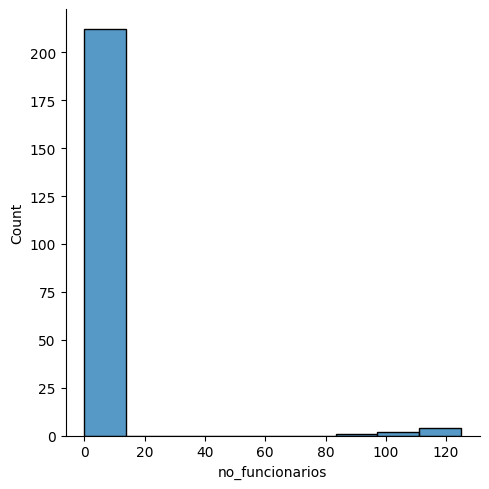

In [237]:
sns.displot(df1.loc[df1['flag_pf']=='PF', 'no_funcionarios']);

In [238]:
# Correção
df1.loc[(df1['flag_pf']=='PF') & (df1['no_funcionarios']>=0), 'no_funcionarios'] = 1

### 1.3.2 - Recheck NA

In [239]:
df1.isna().sum()

id_cliente                0
safra_ref                 0
data_emissao_documento    0
data_pagamento            0
data_vencimento           0
valor_a_pagar             0
taxa                      0
data_cadastro             0
ddd                       0
flag_pf                   0
segmento_industrial       0
dominio_email             0
porte                     0
cep_2_dig                 0
renda_mes_anterior        0
no_funcionarios           0
inadimplente              0
dtype: int64

## 1.4 - Check do desbalanceamento dos dados

Observa-se um **alto desbalanceamento** nos dados.

In [240]:
df1['inadimplente'].value_counts()/df1.shape[0]

inadimplente
0   0.930
1   0.070
Name: count, dtype: float64

## 1.5 - Estatística descritiva

In [241]:
num_attributes = df1.select_dtypes(include=['float64', 'int64'])
cat_attributes = df1.select_dtypes(exclude=['float64', 'int64', 'datetime64[ns]'])

### 1.5.1 - Atributos numéricos

In [242]:
# Tendência central - média, mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenação
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributos', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributos,min,max,range,mean,median,std,skew,kurtosis
0,valor_a_pagar,0.100,4400000.000,4399999.900,46565.461,34751.350,46338.622,16.284,1153.264
1,taxa,4.990,11.990,7.000,6.790,5.990,1.798,1.610,2.233
2,renda_mes_anterior,105.000,1682759.000,1682654.000,290595.466,240302.000,212683.696,1.379,2.625
3,no_funcionarios,1.000,198.000,197.000,117.487,118.000,19.015,-0.532,3.271
4,inadimplente,0.000,1.000,1.000,0.070,0.000,0.256,3.364,9.317





Observa-se nas distribuições a presença de outliers expressivos nas features valor_a_pagar e no_funcionarios. Estes casos serão avaliados mais a fundo.





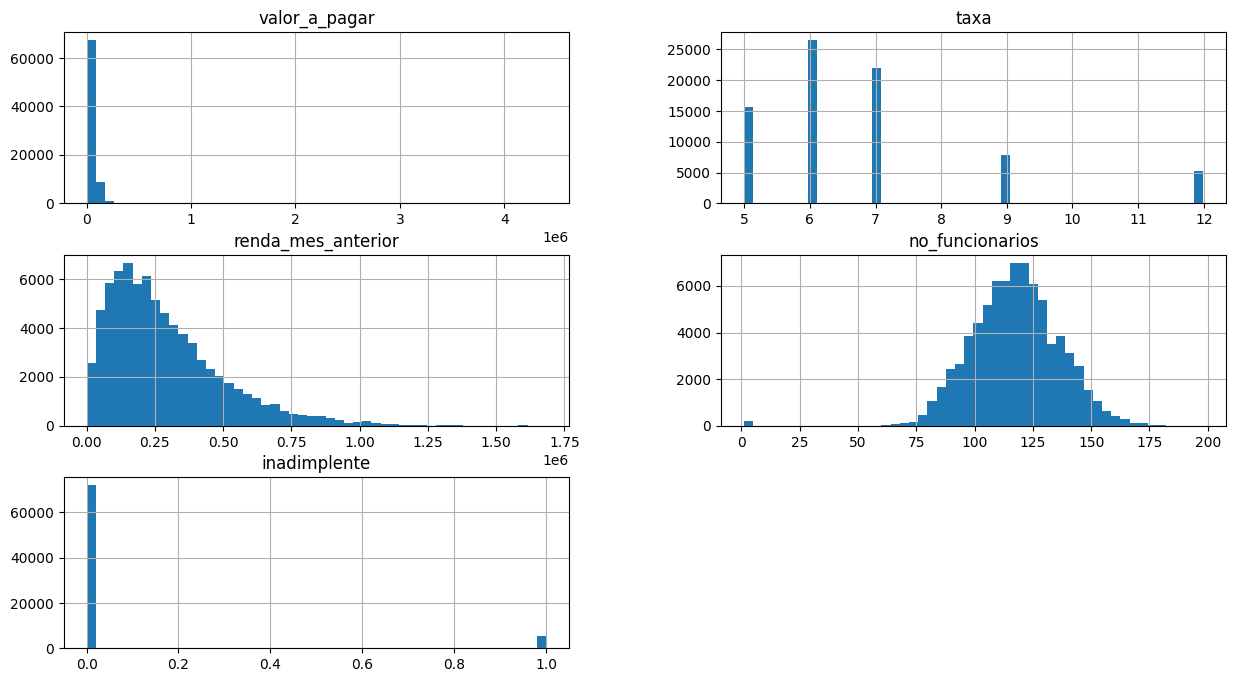

In [243]:
# Plot histograms
fig = plt.figure(figsize=(15, 8))
ax = fig.gca()
num_attributes.hist(ax=ax, bins=50)

print('\n\n\nObserva-se nas distribuições a presença de outliers expressivos nas features valor_a_pagar e no_funcionarios. Estes casos serão avaliados mais a fundo.\n\n\n')

#### Outliers na feature 'no_funcionarios'

Observa-se a presença de pontos isolados à esquerda. Possivelmente são **outliers**.

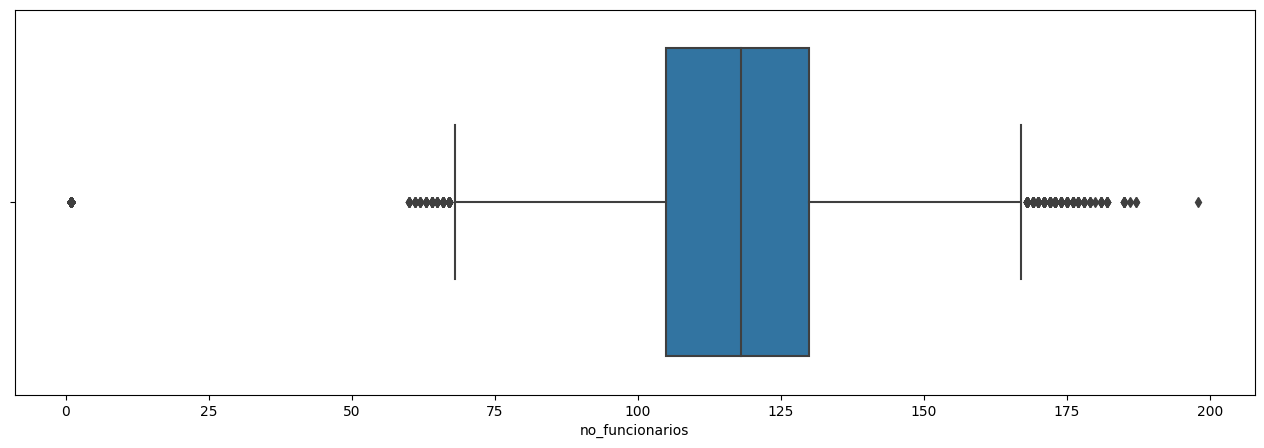

In [244]:
plt.figure(figsize=[16, 5])
sns.boxplot(x='no_funcionarios', data=df1);

In [245]:
# Identificando a quantidade de registros outliers e sua representatividade na base de dados
pontos_isolados = df1.loc[df1['no_funcionarios']==0, :]
print('Nº de registros isolados: {}'.format(pontos_isolados.shape[0]))
print('Representatividade no total de registros: {} %'.format(np.round(100*pontos_isolados.shape[0]/df1.shape[0], 2)))
pontos_isolados.head()

Nº de registros isolados: 0
Representatividade no total de registros: 0.0 %


,id_cliente,safra_ref,data_emissao_documento,data_pagamento,data_vencimento,valor_a_pagar,taxa,data_cadastro,ddd,flag_pf,segmento_industrial,dominio_email,porte,cep_2_dig,renda_mes_anterior,no_funcionarios,inadimplente


In [246]:
# Verificando a influência da variável 'flag_pf' nesses outliers
print('Valores únicos de flag_pf nos outliers: {}'.format(pontos_isolados['flag_pf'].unique()))
print('Valores únicos de flag_pf excluindo os outliers do dataset: {}'.format(df1.loc[df1['no_funcionarios']>25, 'flag_pf'].unique()))

Valores únicos de flag_pf nos outliers: []
Valores únicos de flag_pf excluindo os outliers do dataset: ['PJ']


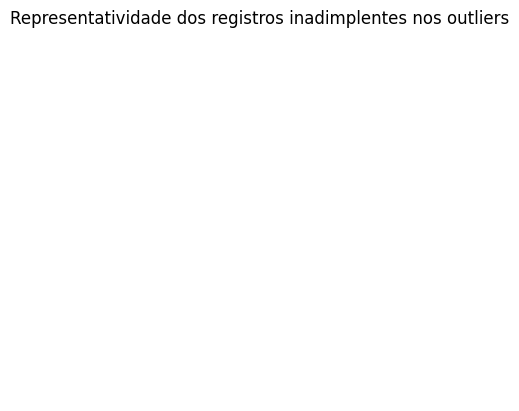

In [247]:
# Representatividade dos registros inadimplentes nesses outliers
pontos_isolados = pontos_isolados.loc[:, ['inadimplente']].groupby('inadimplente').size().reset_index()
pontos_isolados = pontos_isolados.rename(columns={0: 'contagem'})
palette_color = sns.color_palette('bright')
plt.pie(pontos_isolados['contagem'].to_list(), labels=pontos_isolados['inadimplente'].to_list(), colors=palette_color, autopct='%.0f%%')
plt.title('Representatividade dos registros inadimplentes nos outliers');

**CONCLUSÃO:** Os outliers são compostos unicamente por clientes com **'flag_pf'** igual a **'PF'**. Como dos 219 registros 44 são de inadimplentes (20%), foi decidido **não remover** esses outliers e avaliar o impacto disso no modelo de Machine Learning.

#### Outliers na feature 'valor_a_pagar'

Observa-se a presença de vários pontos isolados à direita no BoxPlot. Possivelmente são **outliers**.

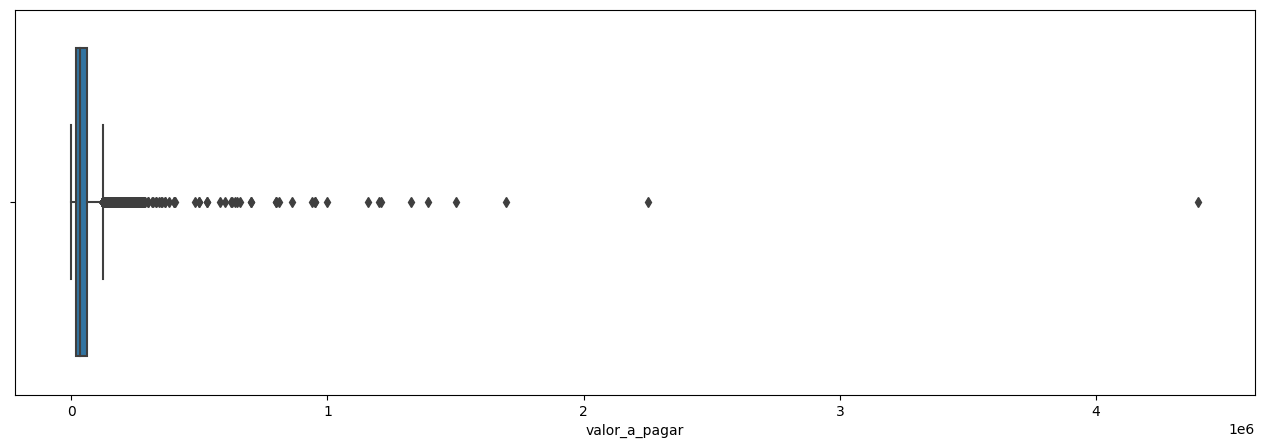

In [248]:
plt.figure(figsize=[16, 5])
sns.boxplot(x='valor_a_pagar', data=df1);

In [249]:
# Definindo o ponto de corte dos outliers pelo Percentile 99 (corte de 1% dos dados)
corte = np.percentile(df1['valor_a_pagar'], 99)
print('Ponto de corte na feature valor_a_pagar: {}'.format(corte))
numero_pontos_cortados = df1.loc[df1['valor_a_pagar']>=corte, 'valor_a_pagar'].shape[0]
print('Quantidade de registros cortados: {}'.format(numero_pontos_cortados))
lista_outliers = df1.loc[df1['valor_a_pagar']>=corte, 'inadimplente'].value_counts().to_list()
print('Representatividade dos registros inadimplentes nos outliers: {}'.format(lista_outliers[1]/lista_outliers[0]))

Ponto de corte na feature valor_a_pagar: 189156.13199999998
Quantidade de registros cortados: 775
Representatividade dos registros inadimplentes nos outliers: 0.06602475928473177


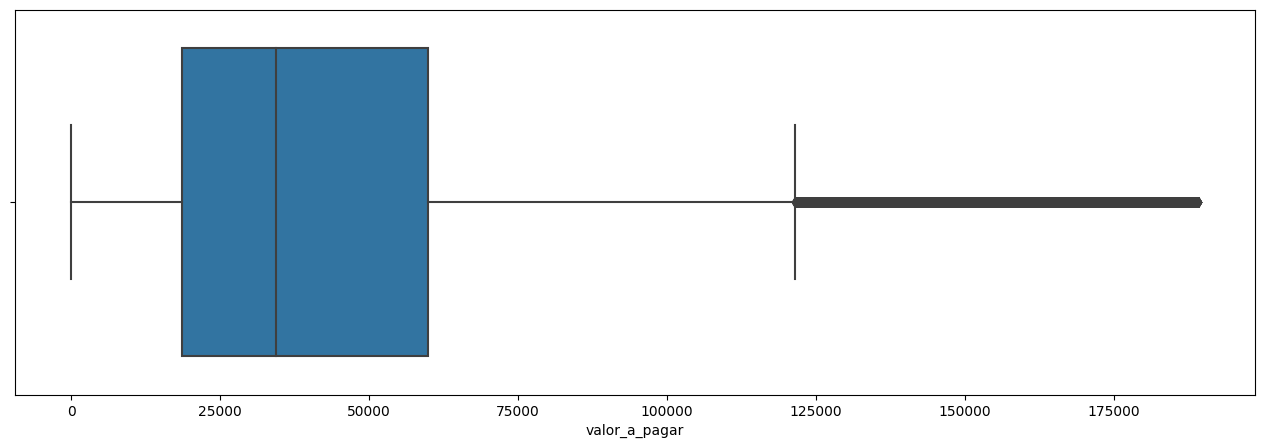

In [250]:
# BoxPlot após o corte de outliers
plt.figure(figsize=[16, 5])
sns.boxplot(x='valor_a_pagar', data=df1.loc[df1['valor_a_pagar']<corte, :]);

**CONCLUSÃO:** Os outliers têm forte presença na feature **'valor_a_pagar'** e a **representatividade** dos registros inadimplentes nos outliers é **baixa**. Decidiu-se cortar **1%** dos pontos da feature. Tal corte será de fato executado na **Seção 3**.

### 1.5.2 - Atributos categóricos

In [251]:
cat_attributes.describe()

,id_cliente,safra_ref,ddd,flag_pf,segmento_industrial,dominio_email,porte,cep_2_dig
count,77414,77414,77414,77414,77414,77414,77414,77414
unique,1248,35,78,2,3,6,3,90
top,6964108750473070287,2021-05,11,PJ,Serviços,YAHOO,MEDIO,13
freq,1151,2531,8972,77195,32400,25720,31330,3888


# 2 - FEATURE ENGINEERING

In [252]:
df2 = df1.copy()

In [253]:
# dif_dias_vencimento_emissao: Diferença entre as datas de vencimento e emissão do documento (tempo para pagar)
df2['dif_dias_vencimento_emissao'] = (df2['data_vencimento'] - df2['data_emissao_documento']).dt.days

df2['dif_vencimento_cadastro'] = (df2['data_vencimento'] - df2['data_cadastro']).dt.days
df2['razao_tempo_pagar_cadastro'] = df2.loc[:, ['dif_dias_vencimento_emissao', 'dif_vencimento_cadastro']].apply(lambda x: x['dif_dias_vencimento_emissao']/x['dif_vencimento_cadastro'] if x['dif_vencimento_cadastro']!= 0 else
                                                                                                                           0, axis=1)

# dias_cadastrado: Tempo de cadastro do cliente
max_date = df2['data_emissao_documento'].max()
df2['dias_cadastrado'] = (max_date - df2['data_cadastro']).dt.days

# renda_por_funcionario: clientes PF possuem 0 funcionários. Para evitar números infinitos neste cálculo, será considerado 1 funcionario para esses casos
df2['renda_por_funcionario'] = df2.loc[:, ['renda_mes_anterior', 'no_funcionarios']]\
                                  .apply(lambda x: x['renda_mes_anterior']/x['no_funcionarios'] if x['no_funcionarios']>0 else x['renda_mes_anterior']/1, axis=1)

# valor_a_pagar_com_taxa_por_renda: Valor a pagar + taxa dividido pela renda do mês anterior
df2['valor_a_pagar_com_taxa_por_renda'] = (1 + df2['taxa']/100)*df2['valor_a_pagar']/df2['renda_mes_anterior']

# proporcao_taxa_renda
df2['proporcao_taxa_renda'] = df2['taxa']/df2['renda_mes_anterior']

# proporcao_taxa_valor_a_pagar
df2['proporcao_taxa_valor_a_pagar'] = df2['taxa']/df2['valor_a_pagar']

# dia
df2['dia'] = df2['data_emissao_documento'].dt.day

# mes
df2['mes'] = df2['data_emissao_documento'].dt.month

# ano
df2['ano'] = df2['data_emissao_documento'].dt.year

# uf e regiao: Dados retirados de https://www.teleco.com.br/ncelddd.asp
## tabela_ddd
tabela_ddd = pd.DataFrame(
                           [['11', 'SP', 'Sudeste'],
                            ['12', 'SP', 'Sudeste'],
                            ['13', 'SP', 'Sudeste'],
                            ['14', 'SP', 'Sudeste'],
                            ['15', 'SP', 'Sudeste'],
                            ['16', 'SP', 'Sudeste'],
                            ['17', 'SP', 'Sudeste'],
                            ['18', 'SP', 'Sudeste'],
                            ['19', 'SP', 'Sudeste'],
                            ['21', 'RJ', 'Sudeste'],
                            ['22', 'RJ', 'Sudeste'],
                            ['24', 'RJ', 'Sudeste'],
                            ['27', 'ES', 'Sudeste'],
                            ['28', 'ES', 'Sudeste'],
                            ['31', 'MG', 'Sudeste'],
                            ['32', 'MG', 'Sudeste'],
                            ['33', 'MG', 'Sudeste'],
                            ['34', 'MG', 'Sudeste'],
                            ['35', 'MG', 'Sudeste'],
                            ['37', 'MG', 'Sudeste'],
                            ['38', 'MG', 'Sudeste'],
                            ['41', 'PR', 'Sul'],
                            ['42', 'PR', 'Sul'],
                            ['43', 'PR', 'Sul'],
                            ['44', 'PR', 'Sul'],
                            ['45', 'PR', 'Sul'],
                            ['46', 'PR', 'Sul'],
                            ['47', 'SC', 'Sul'],
                            ['48', 'SC', 'Sul'],
                            ['49', 'SC', 'Sul'],
                            ['51', 'RS', 'Sul'],
                            ['53', 'RS', 'Sul'],
                            ['54', 'RS', 'Sul'],
                            ['55', 'RS', 'Sul'],
                            ['61', 'DF', 'Centro-Oeste'],
                            ['62', 'GO', 'Centro-Oeste'],
                            ['63', 'TO', 'Norte'],
                            ['64', 'GO', 'Centro-Oeste'],
                            ['65', 'MT', 'Centro-Oeste'],
                            ['66', 'MT', 'Centro-Oeste'],
                            ['67', 'MS', 'Centro-Oeste'],
                            ['68', 'AC', 'Norte'],
                            ['69', 'RO', 'Norte'],
                            ['71', 'BA', 'Nordeste'],
                            ['73', 'BA', 'Nordeste'],
                            ['74', 'BA', 'Nordeste'],
                            ['75', 'BA', 'Nordeste'],
                            ['77', 'BA', 'Nordeste'],
                            ['79', 'SE', 'Nordeste'],
                            ['81', 'PE', 'Nordeste'],
                            ['82', 'AL', 'Nordeste'],
                            ['83', 'PB', 'Nordeste'],
                            ['84', 'RN', 'Nordeste'],
                            ['85', 'CE', 'Nordeste'],
                            ['86', 'PI', 'Nordeste'],
                            ['87', 'PE', 'Nordeste'],
                            ['88', 'CE', 'Nordeste'],
                            ['89', 'PI', 'Nordeste'],
                            ['91', 'PA', 'Norte'],
                            ['92', 'AM', 'Norte'],
                            ['93', 'PA', 'Norte'],
                            ['94', 'PA', 'Norte'],
                            ['95', 'RR', 'Norte'],
                            ['96', 'AP', 'Norte'],
                            ['97', 'AM', 'Norte'],
                            ['98', 'MA', 'Nordeste'],
                            ['99', 'MA', 'Nordeste']],
                            columns=['ddd', 'uf', 'regiao'])

## Merge
df2 = pd.merge(df2, tabela_ddd, how='left', on='ddd')
df2['uf'].fillna('Indefinido', inplace=True)
df2['regiao'].fillna('Indefinido', inplace=True)

In [254]:
safra_ref = list(df2['safra_ref'].unique())
auz = pd.DataFrame()
for i in safra_ref:
    auy = df2.loc[df2['safra_ref']==i, :]
    auy = auy.loc[:, ['id_cliente', 'taxa', 'valor_a_pagar']].groupby('id_cliente').agg(total_valor_a_pagar=('valor_a_pagar', 'sum'),
                                                                                        media_valor_a_pagar=('valor_a_pagar', 'mean'),
                                                                                        contagem=('valor_a_pagar', 'count'),
                                                                                        media_taxa=('taxa', 'mean')).reset_index()
    auy['safra_ref'] = i
    auy['valor_taxa'] = auy.loc[:, 'total_valor_a_pagar'] * auy.loc[:, 'media_taxa']/100
    auz = pd.concat([auz, auy])
df2 = pd.merge(df2, auz, how='left', on=['safra_ref', 'id_cliente'])

df2['renda_menos_valor_taxa'] = df2.loc[:, 'renda_mes_anterior'] - df2.loc[:, 'valor_taxa']
df2['renda_menos_valor_taxa_por_funcionario'] = df2.loc[:, 'renda_menos_valor_taxa']/df2.loc[:, 'no_funcionarios']  
df2['renda_remanescente'] = df2.loc[:, 'renda_menos_valor_taxa']/df2.loc[:, 'renda_mes_anterior']

In [255]:
df2.isna().sum()

id_cliente                                0
safra_ref                                 0
data_emissao_documento                    0
data_pagamento                            0
data_vencimento                           0
valor_a_pagar                             0
taxa                                      0
data_cadastro                             0
ddd                                       0
flag_pf                                   0
segmento_industrial                       0
dominio_email                             0
porte                                     0
cep_2_dig                                 0
renda_mes_anterior                        0
no_funcionarios                           0
inadimplente                              0
dif_dias_vencimento_emissao               0
dif_vencimento_cadastro                   0
razao_tempo_pagar_cadastro                0
dias_cadastrado                           0
renda_por_funcionario                     0
valor_a_pagar_com_taxa_por_renda

# 3 - FILTRAGEM DOS DADOS

In [256]:
df3 = df2.copy()

## 3.1 - Avaliação de outliers nas features geradas na seção 2

A avaliação consistirá na **análise do histograma** das features criadas.

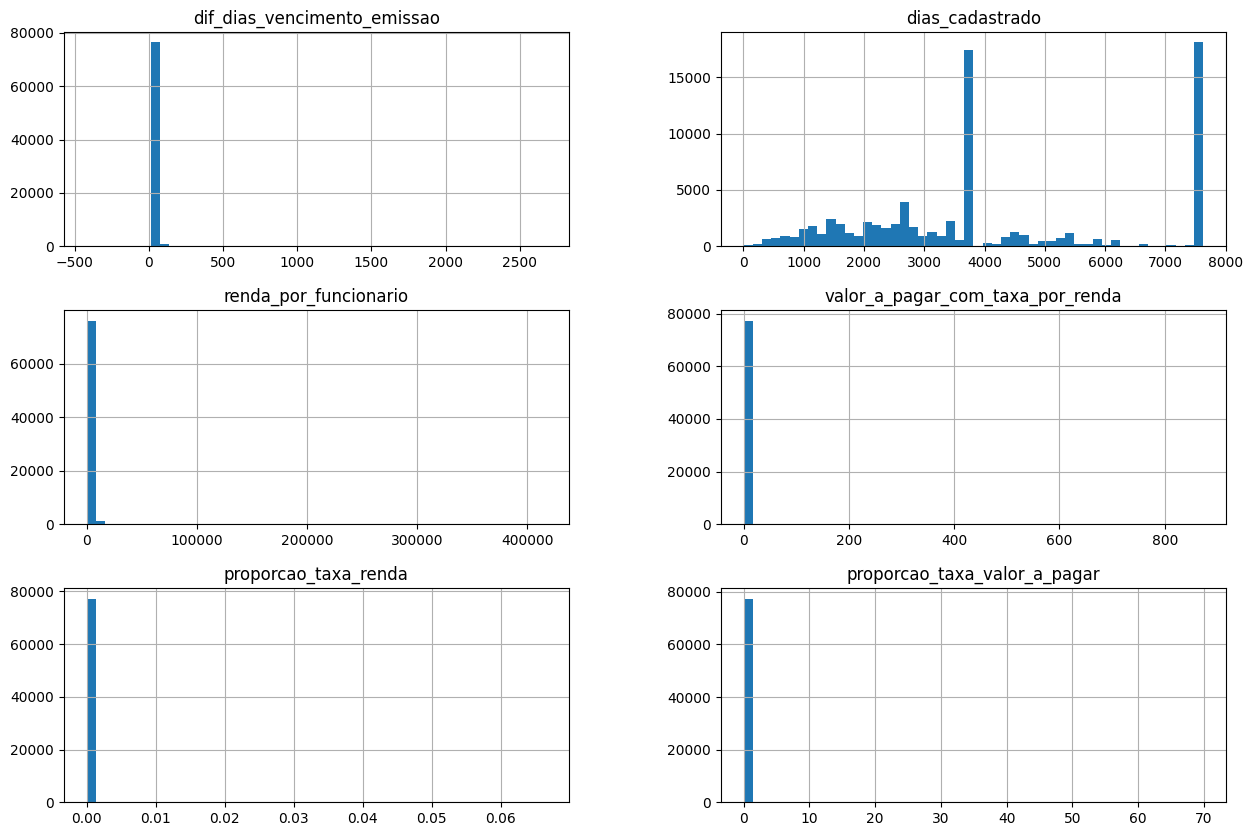

In [257]:
# Plotando os histogramas
cols_created = ['dif_dias_vencimento_emissao', 'dias_cadastrado', 'renda_por_funcionario', 'valor_a_pagar_com_taxa_por_renda', 
                'proporcao_taxa_renda', 'proporcao_taxa_valor_a_pagar']
# Plot histogramas
fig = plt.figure(figsize=(15, 10))
ax = fig.gca()
df3.loc[:, cols_created].hist(ax=ax, bins=50);

-----------------------------------

**ANÁLISE** 
1. Como se observa, a maioria das variáveis possuem **longas caudas à direita** (a feature 'dif_dias_vencimento_emissao' também possui cauda à esquerda), exceto a feature 'dias_cadastrado' que, apesar dos 2 picos, aparentemente não possui outliers. 
2. Serão considerados como outliers os pontos após o percentil 99 (1% dos dados). É feita uma avaliação da **representatividade dos registros inadimplentes** nos outliers.

------------------------

In [258]:
# Construção de dataframe para observação da representatividades dos registros inadimplentes nos outliers
lista_outliers = []
for i in cols_created:
    corte = np.percentile(df3[i], 99)
    lista = df3.loc[df3[i]>=corte, 'inadimplente'].value_counts().to_list()
    lista.append(lista[1]/lista[0])
    lista.append(i)
    lista_outliers.append(lista)
    
lista_outliers = pd.DataFrame(lista_outliers, columns=['total_registros', 'total_registros_inadimplentes', 'representatividade_outliers', 'feature'])
lista_outliers.loc[:, ['feature', 'total_registros', 'total_registros_inadimplentes', 'representatividade_outliers']]

,feature,total_registros,total_registros_inadimplentes,representatividade_outliers
0,dif_dias_vencimento_emissao,632,151,0.239
1,dias_cadastrado,17047,1043,0.061
2,renda_por_funcionario,716,59,0.082
3,valor_a_pagar_com_taxa_por_renda,608,167,0.275
4,proporcao_taxa_renda,490,285,0.582
5,proporcao_taxa_valor_a_pagar,524,259,0.494


-----------------------------------

**CONCLUSÃO** 
1. A **presença** de registro de inadimplentes nos outliers é **significativa** na maioria das variáveis, logo, isso **inviabiliza a exclusão** desses pontos do dataset de trabalho, pois podem ser **importantes** para a modelagem da solução.
2. Apesar da baixa representatividade dos inadimplentes nas variáveis 'dias_cadastrado' e 'renda_por_funcionario', foi decidido manter os outliers no dataset de trabalho, pois aparentam não prejudicar a modelagem a ser construída.

------------------------

## 3.2 - Seleção de linhas

Como mencionado na **Seção 1.5.1**, o corte de dados será em **'valor_a_pagar' = 189156.13199999998**.

In [259]:
# Remoção de outliers de 'valor_a_pagar'
corte = np.percentile(df1['valor_a_pagar'], 99)
df3 = df3.loc[df3['valor_a_pagar'] < corte, :]

## 3.3 - Seleção de colunas

In [260]:
df3 = df3.drop(['data_emissao_documento', 'data_pagamento', 'data_vencimento', 'data_cadastro'], axis=1)

# 4 - ANÁLISE EXPLORATÓRIA DE DADOS

In [261]:
df4 = df2.copy()

# Remoção de outliers de 'valor_a_pagar'
corte = np.percentile(df2['valor_a_pagar'], 99)
df4 = df4.loc[df4['valor_a_pagar'] < corte, :]

## 4.1 - Análise univariada

### 4.1.1 - Atributos numéricos

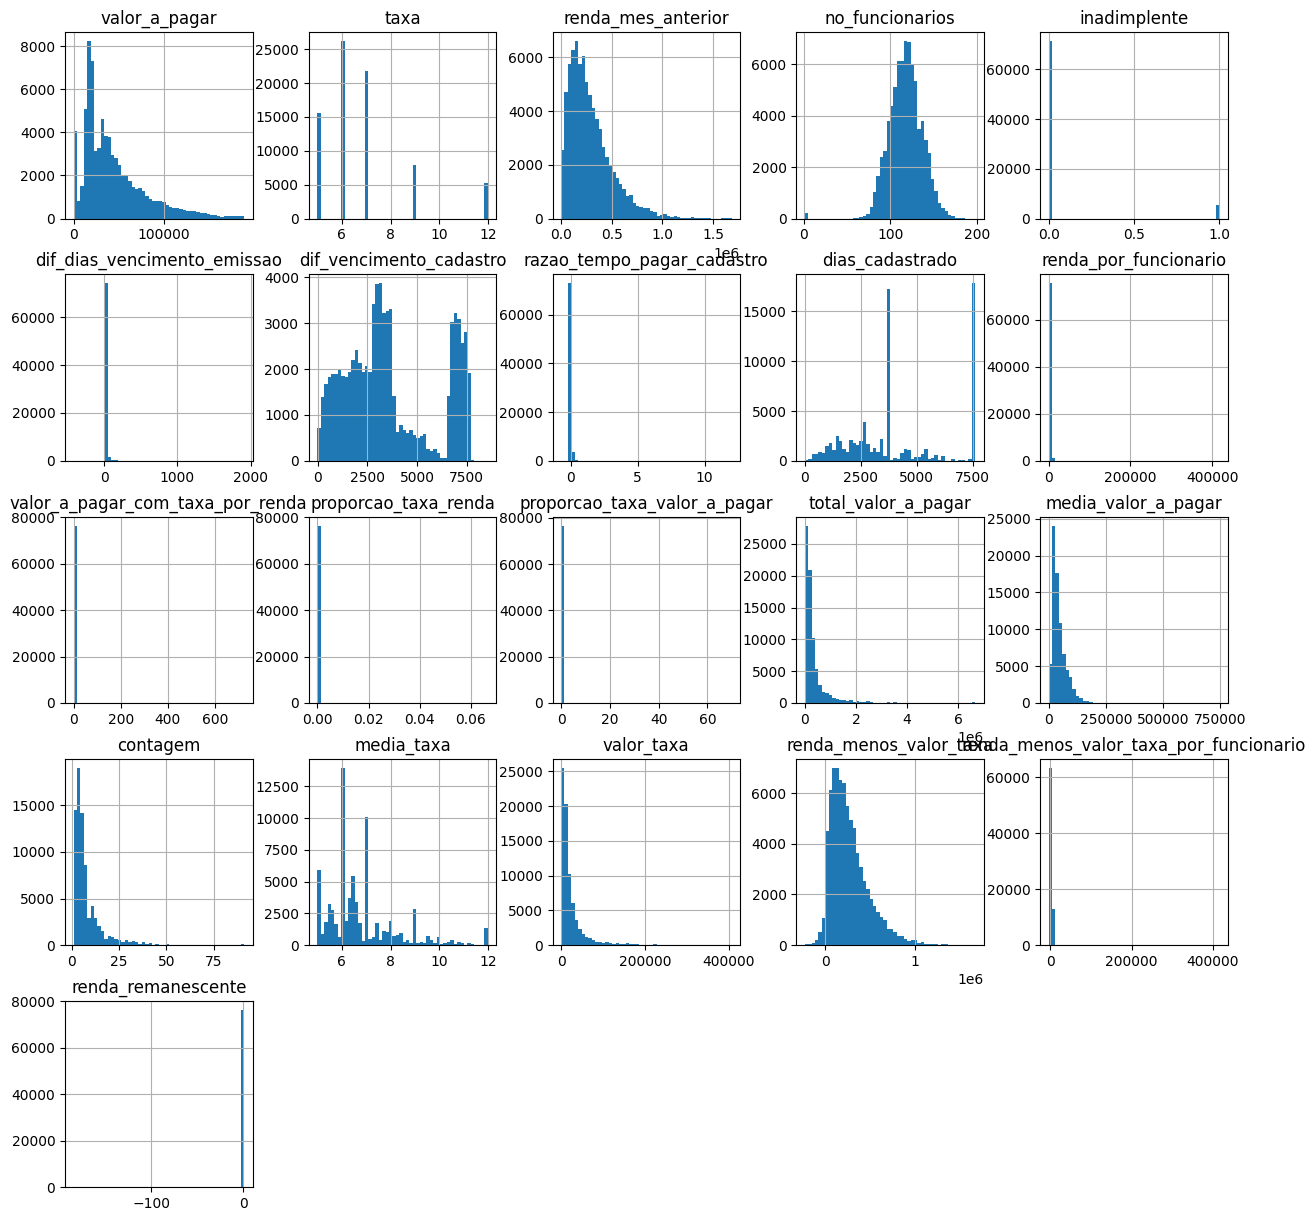

In [262]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])

# Plot histogramas
fig = plt.figure(figsize=(15,15))
ax = fig.gca()
num_attributes.hist(ax=ax, bins=50);

### 4.1.2 - Atributos categóricos

#### Representatividade: flag_pf, segmento_industrial, dominio_email e porte

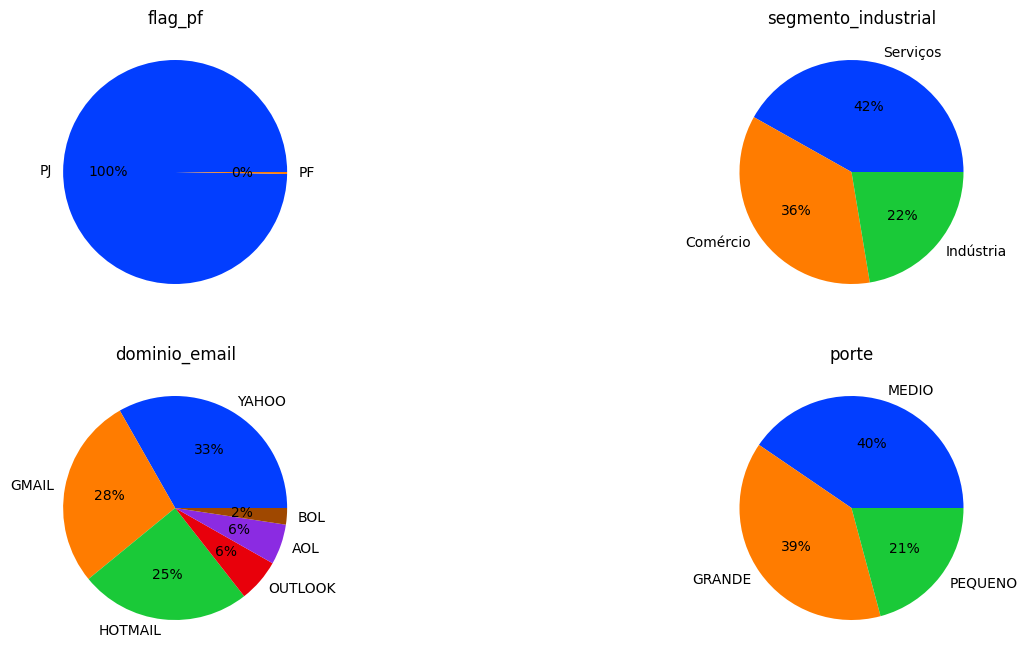

In [263]:
# Colunas selecionadas para representação gráfica
cols_selected = ['flag_pf', 'segmento_industrial', 'dominio_email', 'porte']

plt.figure(figsize=[16, 8])
palette_color = sns.color_palette('bright')
j = 1
for i in cols_selected:
    # Data Frame
    aux = pd.DataFrame(cat_attributes[i].value_counts().reset_index())
    aux.columns = [i, 'counts']
    
    #plot
    plt.subplot(2, 2, j)
    plt.pie(aux['counts'].to_list(), labels=aux[i].to_list(), colors=palette_color, autopct='%.0f%%')
    plt.title(i)
    j = j + 1

plt.show()

#### Variáveis ddd e cep_2_dig

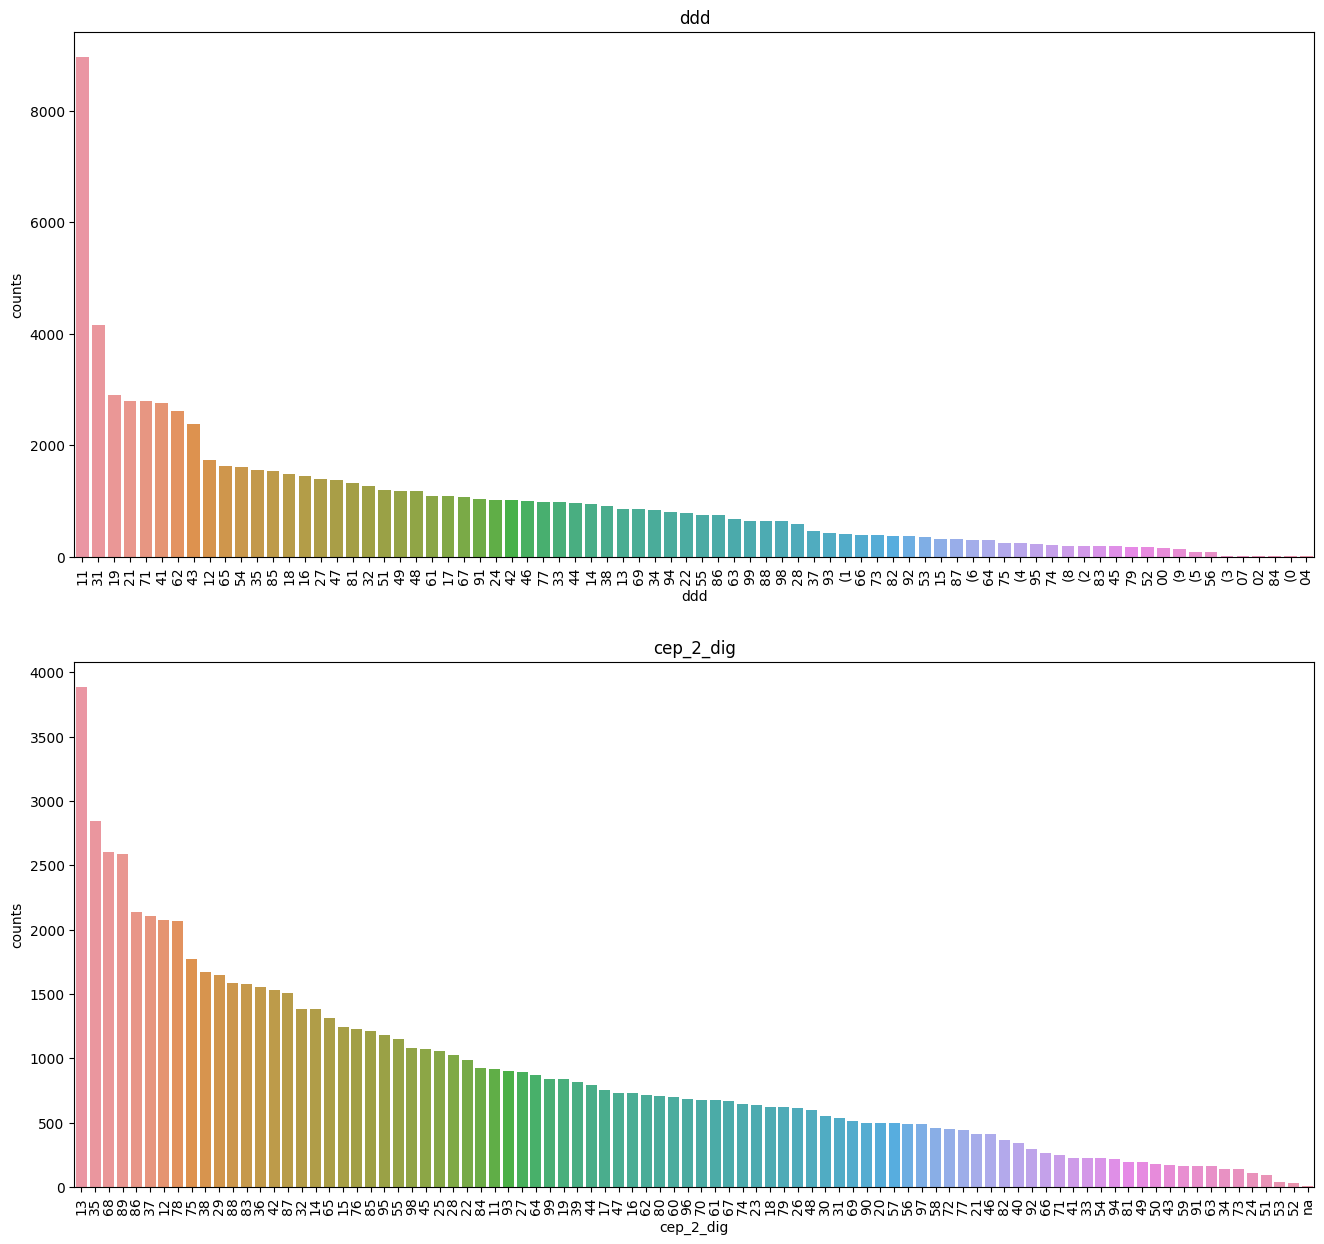

In [264]:
# Colunas selecionadas para representação gráfica
cols_selected = ['ddd', 'cep_2_dig']

plt.figure(figsize=[16, 15])
j = 1
for i in cols_selected:
    # Data Frame
    aux = pd.DataFrame(cat_attributes[i].value_counts().reset_index())
    aux.columns = [i, 'counts']
    
    #plot
    plt.subplot(2, 1, j)
    sns.barplot(x=i, y='counts', data=aux)
    plt.xticks(rotation=90)
    plt.title(i)
    j = j + 1

## 4.2 - Análise bivariada

**COMO SERÁ FEITO:** A análise bivariada é realizada através da confirmação de **HIPÓTESES DO NEGÓCIO**.

### 1. Mais de 40% dos pedidos de crédito inadimplentes estão na região Sudeste.

**FALSO** Menos de 40% dos inadimplentes estão na região Sudeste.

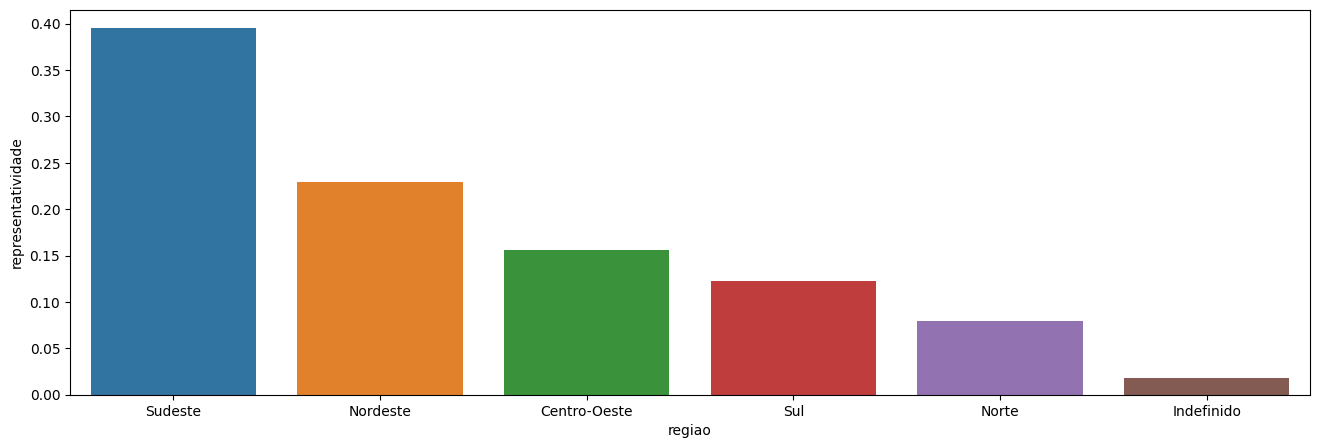

In [265]:
# Dataframe
aux = df4.loc[df4['inadimplente']==1, ['regiao', 'inadimplente']]
aux = aux.groupby('regiao').sum().reset_index()
total_inadimplentes = aux['inadimplente'].sum()
aux['representatividade'] = aux['inadimplente']/total_inadimplentes
aux = aux.sort_values('representatividade', ascending=False)

# Plot
plt.figure(figsize=[16, 5])
sns.barplot(x='regiao', y='representatividade', data=aux);

### 2. A região Sul é a que possui a menor representatividade de pedidos de crédito inadimplentes.

**VERDADEIRO** A menor taxa de transações inadimplentes é da região Sul.

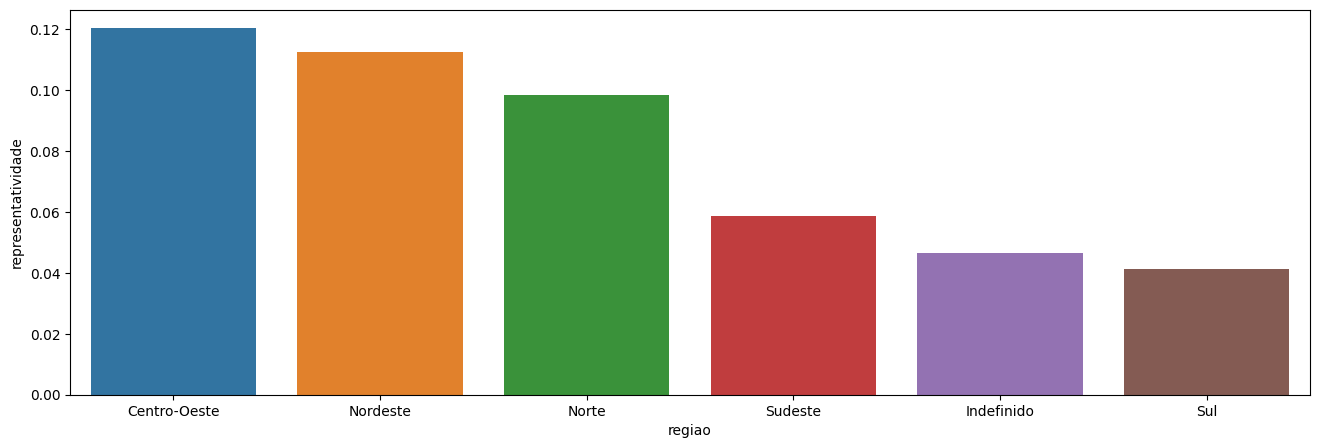

In [266]:
# Dataframe
aux = df4.loc[df4['inadimplente']==1, ['regiao', 'inadimplente']]
aux = aux.groupby('regiao').sum().reset_index()
aux2 = df4.loc[:, ['regiao']]
aux2 = aux2.groupby('regiao').size().reset_index()
aux2 = aux2.rename(columns={0: 'total_transacoes'})
aux = pd.merge(aux, aux2, how='left', on='regiao')
aux['representatividade'] = aux['inadimplente']/aux['total_transacoes']
aux = aux.sort_values('representatividade', ascending=False)

# Plot
plt.figure(figsize=[16, 5])
sns.barplot(x='regiao', y='representatividade', data=aux);

### 3. São Paulo possui mais de 20% dos pedidos de crédito inadimplentes.

**VERDADEIRO** Mais de 20% dos inadimplentes estão no estado de São Paulo.

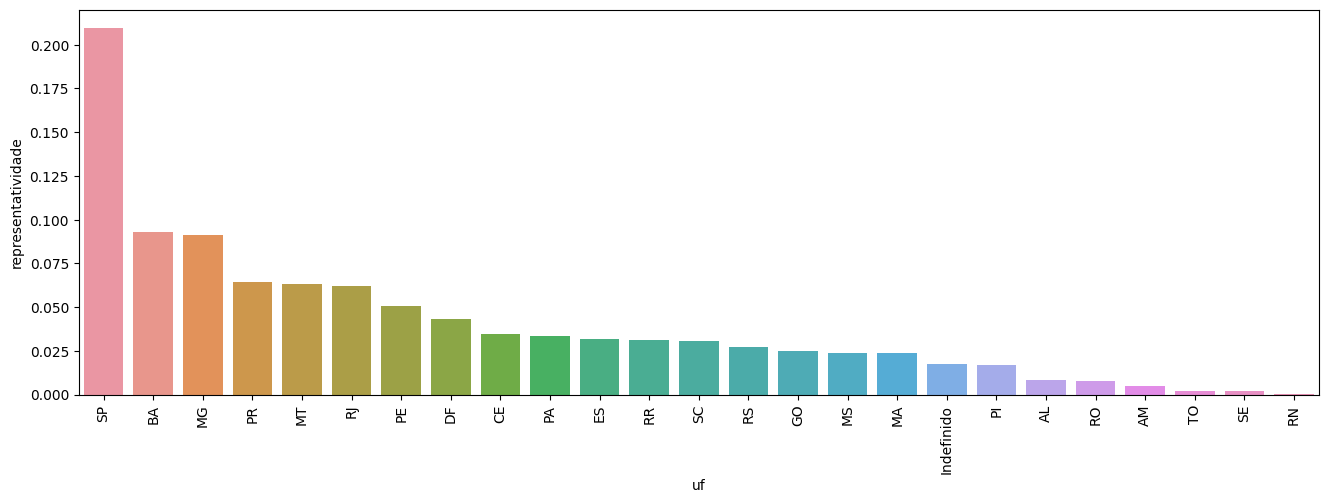

In [267]:
# Dataframe
aux = df4.loc[df4['inadimplente']==1, ['uf', 'inadimplente']]
aux = aux.groupby('uf').sum().reset_index()
total_inadimplentes = aux['inadimplente'].sum()
aux['representatividade'] = aux['inadimplente']/total_inadimplentes
aux = aux.sort_values('representatividade', ascending=False)

# Plot
plt.figure(figsize=[16, 5])
sns.barplot(x='uf', y='representatividade', data=aux)
plt.xticks(rotation=90);

### 4. A região do Sudeste detém mais de 40% dos clientes que já foram inadimplentes alguma vez no histórico.

**VERDADEIRO** A região sudeste possui mais de 40% dos clientes inadimplentes no histórico de dados.

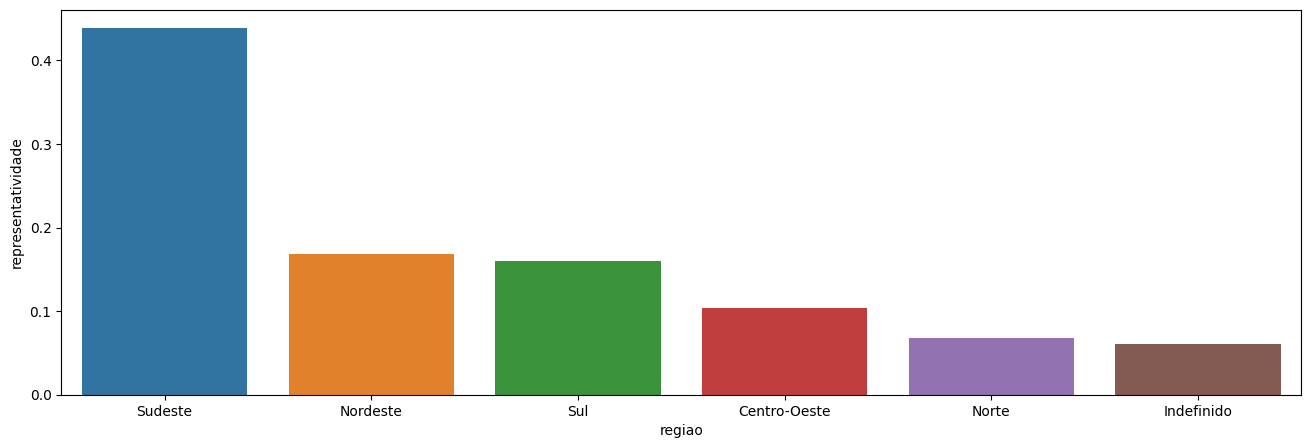

In [268]:
# Dataframe
aux = df4.loc[df4['inadimplente']==1, ['id_cliente', 'regiao']]
aux = aux.drop_duplicates('id_cliente')
total_clientes_inadimplentes = aux.shape[0]
aux = aux.groupby('regiao').size().reset_index()
aux = aux.rename(columns={0: 'inadimplente'})
aux['representatividade'] = aux['inadimplente']/total_clientes_inadimplentes
aux = aux.sort_values('representatividade', ascending=False)

# Plot
plt.figure(figsize=[16, 5])
sns.barplot(x='regiao', y='representatividade', data=aux);

### 5. O estado de São Paulo detém mais de 40% dos clientes que já foram inadimplentes alguma vez no histórico.

**FALSO** A região sudeste detém menos de 40% dos clientes inadimplentes no histórico de dados.

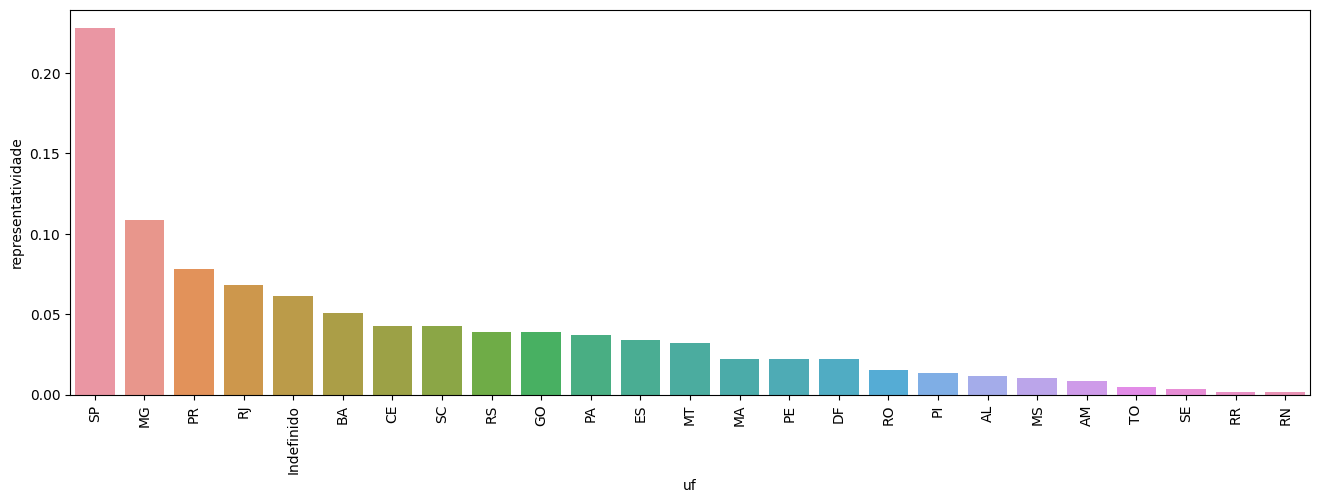

In [269]:
# Dataframe
aux = df4.loc[df4['inadimplente']==1, ['id_cliente', 'uf']]
aux = aux.drop_duplicates('id_cliente')
total_clientes_inadimplentes = aux.shape[0]
aux = aux.groupby('uf').size().reset_index()
aux = aux.rename(columns={0: 'inadimplente'})
aux['representatividade'] = aux['inadimplente']/total_clientes_inadimplentes
aux = aux.sort_values('representatividade', ascending=False)

# Plot
plt.figure(figsize=[16, 5])
sns.barplot(x='uf', y='representatividade', data=aux)
plt.xticks(rotation=90);

### 6. Empresas de porte menor possuem mais pedidos de crédito inadimplentes.

**FALSO** As empresas de pequeno são as que têm menos pedidos de crédito inadimplentes. As médio porte possuem a maior taxa.

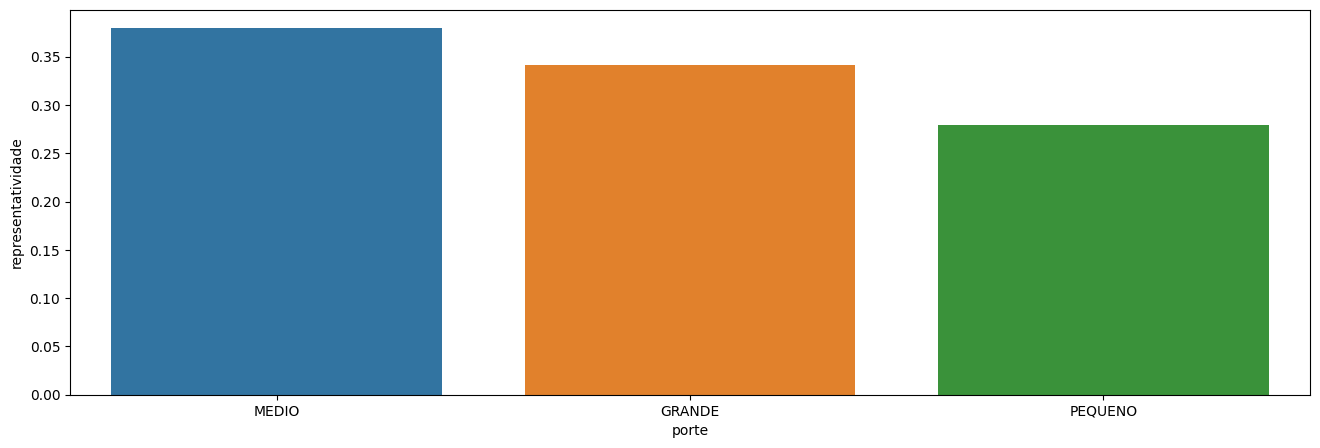

In [270]:
# Dataframe
aux = df4.loc[df4['inadimplente']==1, ['porte', 'inadimplente']]
aux = aux.groupby('porte').sum().reset_index()
total_inadimplentes = aux['inadimplente'].sum()
aux['representatividade'] = aux['inadimplente']/total_inadimplentes
aux = aux.sort_values('representatividade', ascending=False)

# Plot
plt.figure(figsize=[16, 5])
sns.barplot(x='porte', y='representatividade', data=aux);

### 7. Empresas do segmento Comércio possuem mais pedidos de crédito inadimplentes.

**FALSO** As empresas do segmento Comércio são as que têm menos pedidos de crédito inadimplentes. As do segmento Serviços possuem a maior taxa.

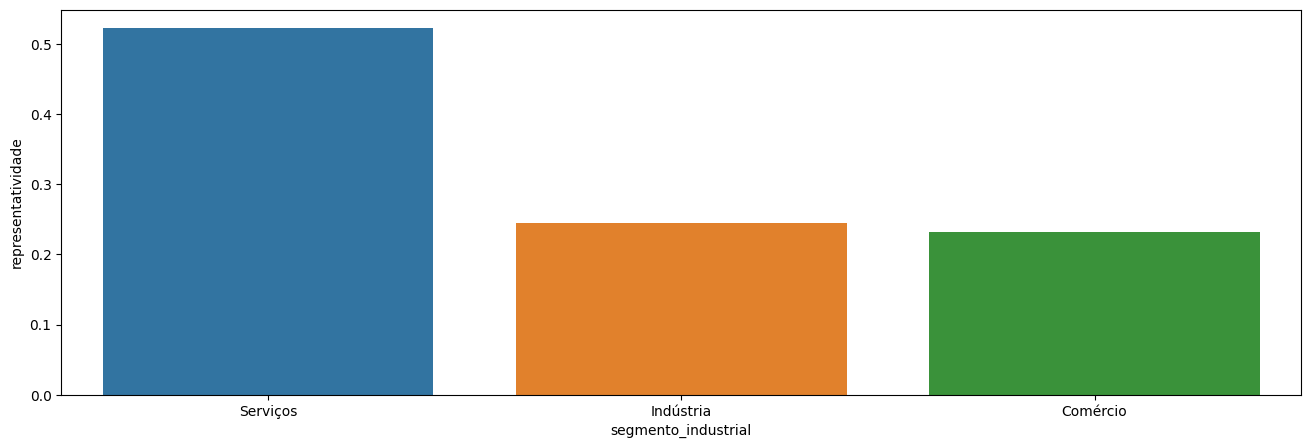

In [271]:
# Dataframe
aux = df4.loc[df4['inadimplente']==1, ['segmento_industrial', 'inadimplente']]
aux = aux.groupby('segmento_industrial').sum().reset_index()
total_inadimplentes = aux['inadimplente'].sum()
aux['representatividade'] = aux['inadimplente']/total_inadimplentes
aux = aux.sort_values('representatividade', ascending=False)

# Plot
plt.figure(figsize=[16, 5])
sns.barplot(x='segmento_industrial', y='representatividade', data=aux);

### 8. Clientes mais antigos possuem taxa de inadimplência menor

**FALSO** Não há correlação entre os dias cadastrado do cliente e sua taxa de inadimplência, como mostra n gráfico heatmap.

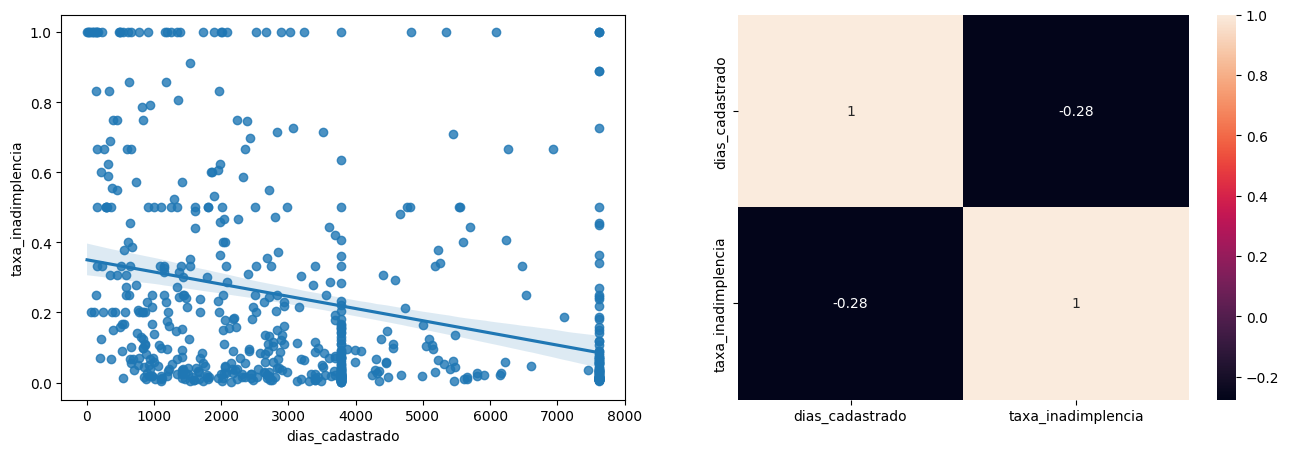

In [272]:
# Dataframe
aux = df4.loc[:, ['dias_cadastrado', 'inadimplente', 'id_cliente']]
aux = aux.groupby(['id_cliente', 'dias_cadastrado', 'inadimplente']).size().reset_index()
aux = aux.rename(columns={0: 'qtde_pedidos'})
aux2 = aux.loc[:, ['id_cliente', 'qtde_pedidos']].groupby('id_cliente').sum().reset_index()
aux2 = aux2.rename(columns={'qtde_pedidos': 'total_pedidos'})
aux = pd.merge(aux, aux2, how='left', on='id_cliente')
aux['taxa_inadimplencia'] = aux['qtde_pedidos']/aux['total_pedidos']
aux = aux.loc[aux['inadimplente']==1, ['dias_cadastrado', 'taxa_inadimplencia']]

# Plot
plt.figure(figsize=[16, 5])
plt.subplot(1, 2, 1)
sns.regplot(x='dias_cadastrado', y='taxa_inadimplencia', data=aux)

plt.subplot(1, 2, 2)
sns.heatmap(aux.corr(method='pearson'), annot=True);

### 9. Quanto maior a renda mensal média da empresa, menor a sua taxa de inadimplência

**VERDADEIRO** Há uma correlação de força média entre a renda mensal média e taxa de inadimplência de modo que quanto maior a renda, menor a taxa.

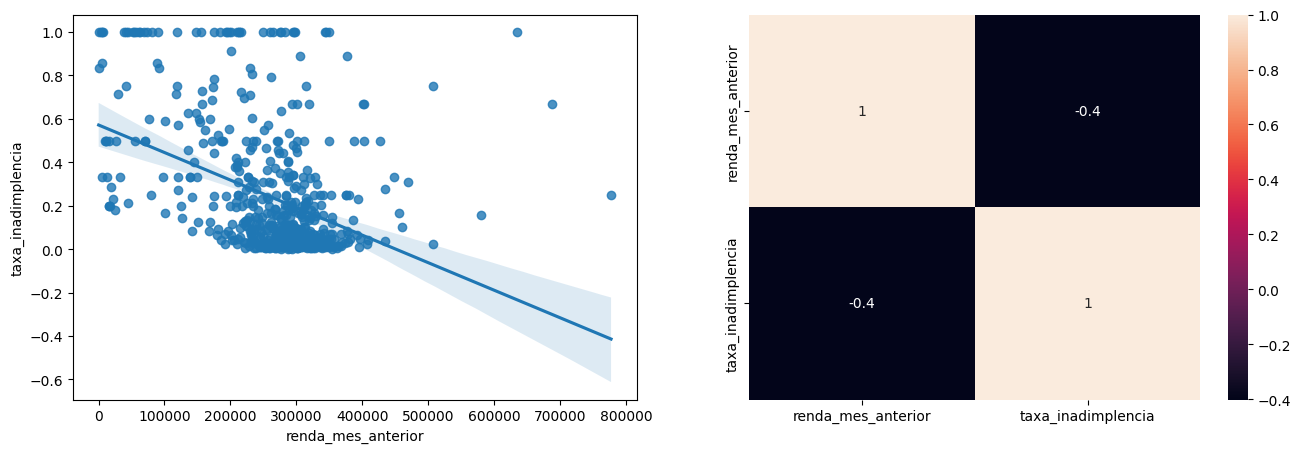

In [273]:
# Dataframe
## Taxa de inadimplência
aux = df4.loc[:, ['inadimplente', 'id_cliente']]
aux = aux.groupby(['id_cliente', 'inadimplente']).size().reset_index()
aux = aux.rename(columns={0: 'qtde_pedidos'})
aux2 = aux.loc[:, ['id_cliente', 'qtde_pedidos']].groupby('id_cliente').sum().reset_index()
aux2 = aux2.rename(columns={'qtde_pedidos': 'total_pedidos'})
aux = pd.merge(aux, aux2, how='left', on='id_cliente')
aux['taxa_inadimplencia'] = aux['qtde_pedidos']/aux['total_pedidos']
aux = aux.loc[aux['inadimplente']==1, ['id_cliente', 'taxa_inadimplencia']]

## Renda mensal média
aux2 = df4.loc[:, ['id_cliente', 'safra_ref', 'renda_mes_anterior']]
aux2 = aux2.drop_duplicates(['id_cliente', 'safra_ref'])
aux2 = aux2.loc[:, ['id_cliente', 'renda_mes_anterior']].groupby('id_cliente').mean().reset_index()

# Merge
aux = pd.merge(aux, aux2, how='left', on='id_cliente')
aux = aux.loc[:, ['renda_mes_anterior', 'taxa_inadimplencia']]

# Plot
plt.figure(figsize=[16, 5])
plt.subplot(1, 2, 1)
sns.regplot(x='renda_mes_anterior', y='taxa_inadimplencia', data=aux)

plt.subplot(1, 2, 2)
sns.heatmap(aux.corr(method='pearson'), annot=True);

### 10. Os registros de inadimplência aumentam com o passar dos meses.

**FALSO** Não há tendência no aumento do registro de inadimplências ao longo dos meses.

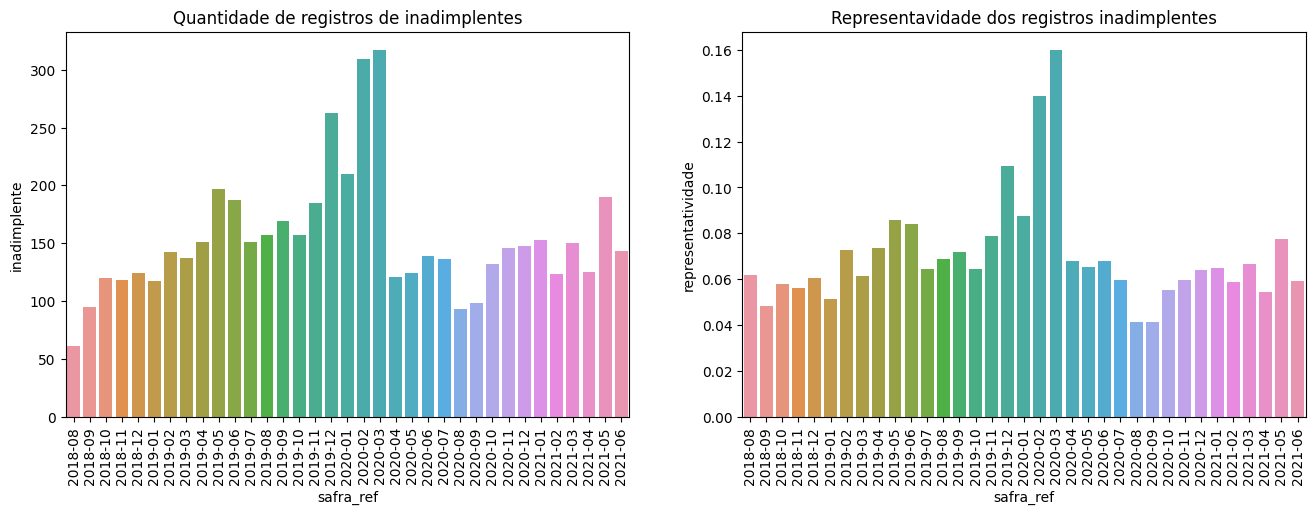

In [274]:
# Dataframe
aux = df4.loc[df4['inadimplente']==1, ['inadimplente', 'safra_ref']].groupby('safra_ref').sum().reset_index()
total_registros = df4.loc[:, ['safra_ref']].groupby('safra_ref').size().reset_index()
total_registros = total_registros.rename(columns={0: 'contagem'})
aux2 = pd.merge(aux, total_registros, how='left', on='safra_ref')
aux2['representatividade'] = aux2['inadimplente']/aux2['contagem']

# Plot
plt.figure(figsize=[16, 5])

plt.subplot(1, 2, 1)
sns.barplot(x='safra_ref', y='inadimplente', data=aux)
plt.xticks(rotation=90)
plt.title('Quantidade de registros de inadimplentes')

plt.subplot(1, 2, 2)
sns.barplot(x='safra_ref', y='representatividade', data=aux2)
plt.xticks(rotation=90)
plt.title('Representavidade dos registros inadimplentes');

## 4.3 - Análise multivariada

### 4.3.1 - Atributos numéricos

**ANÁLISE:** A correlação de **Pearson** (comumente utilizada) mostrou fraquíssimas correlações entre as variáveis, logo as variáveis não possuem relações de linearidade. Nesse caso, decidiu-se utilizar a correlação de **Kendall** (mais apropriada para detectar relações não lineares). Observa-se que a **grande maioria** das variáveis possuem **fracas correlações** entre si.

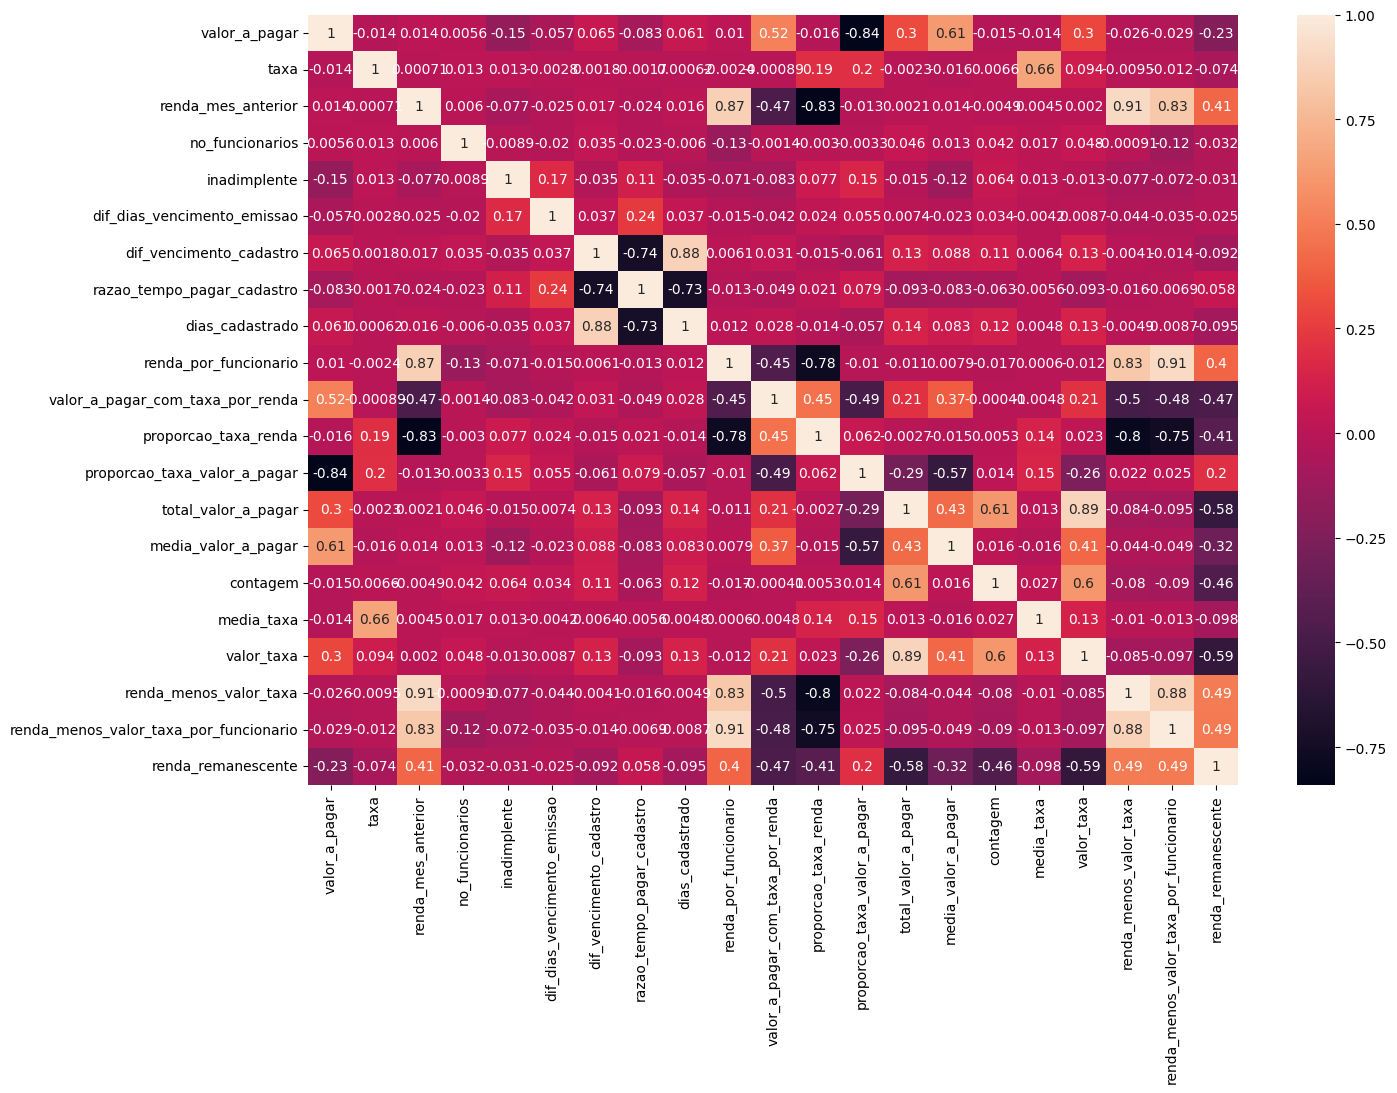

In [275]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(15, 10))
correlation = num_attributes.corr(method='kendall')
sns.heatmap(correlation, annot=True);

### 4.3.2 - Atributos categóricos

**ANÁLISE:** As variáveis **categóricas** possuem um número maior de correlações **fortes** quando se compara ao caso das variáveis numéricas. Isso pode ser positivo a modelagem dos algoritmos de Machine Learning.

In [276]:
cat_attributes = df3.select_dtypes(exclude=['int64', 'float64'])
cat_attributes_list = cat_attributes.columns.tolist()#.drop('id_cliente', axis=1).columns.tolist()

corr_dict = {}
for i in range(len(cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # append a list
        corr_list.append(corr)
    
    # appende a correlation list for each ref attributs
    corr_dict[ref] = corr_list

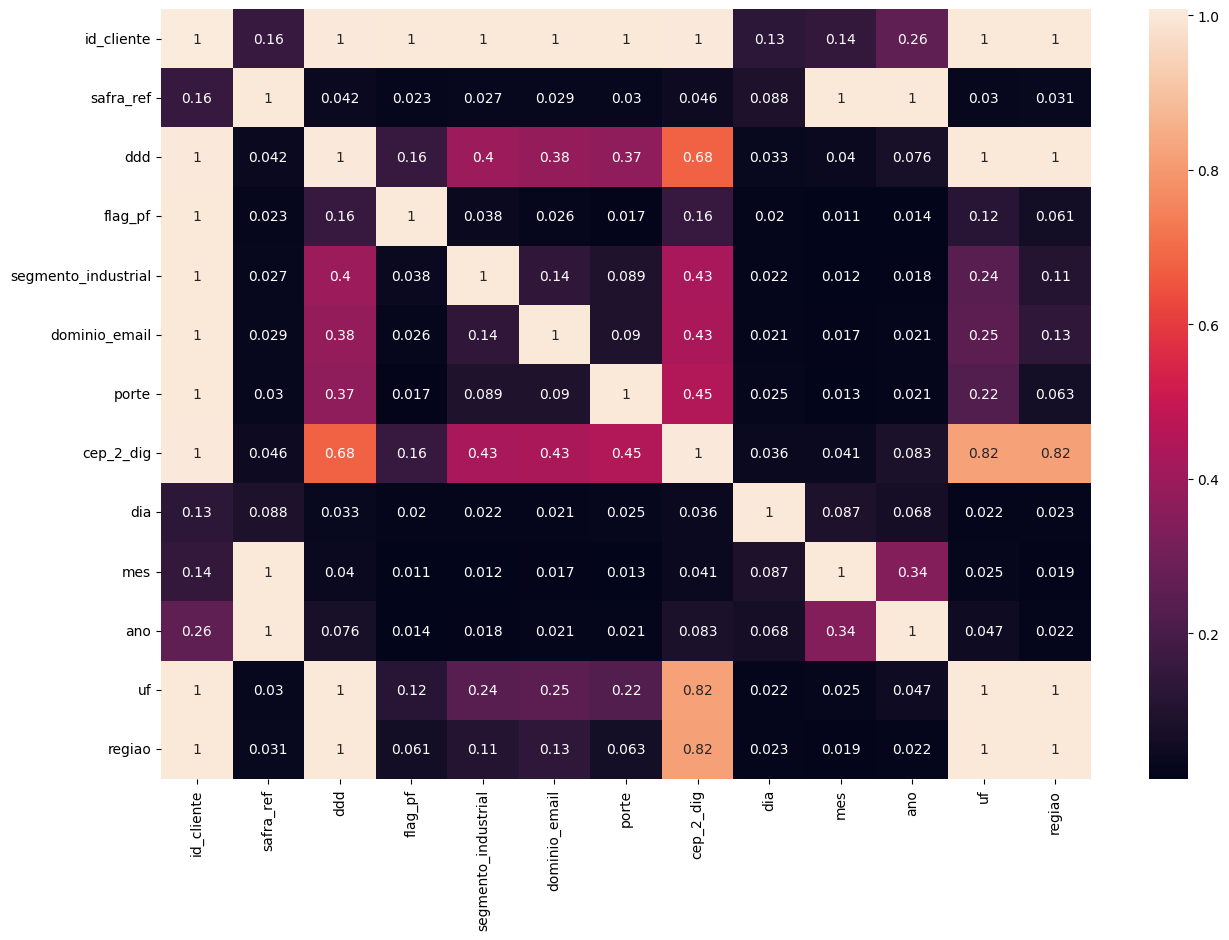

In [277]:
plt.figure(figsize=(15,10))
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

# 5 - PREPARAÇÃO DOS DADOS

In [278]:
x = df3.copy()

## 5.1 - Encoding

In [279]:
# Label encoder
cols_object_label = ['ddd', 'cep_2_dig', 'uf', 'id_cliente', 'flag_pf', 'segmento_industrial', 'dominio_email', 'porte', 'regiao']
le = pp.LabelEncoder()
for i in cols_object_label:
    x[i] = le.fit_transform(x[i])
    pickle.dump(le, open('parameters/' + i + '.pkl', 'wb'))

In [280]:
# Definição de um dataframe 'Out of time' para validação dos modelos de Machine Learning
df_oot = x.loc[x['safra_ref'].isin(['2021-05', '2021-06']), :].drop('safra_ref', axis=1)

# Salvamento dataframe original 'Out of time' para ser usado mais a frente
df_oot_save = df_oot.copy()

In [281]:
# Dataframe descontando o df 'Out of time'
y = x.loc[~x['safra_ref'].isin(['2021-05', '2021-06']), 'inadimplente']
x = x.loc[~x['safra_ref'].isin(['2021-05', '2021-06']), :].drop(['safra_ref', 'inadimplente'], axis=1)

## 5.1 - Train and test split

O df 'Out of time' não entra na divisão de treino e teste.

In [282]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

## 5.2 - Balanceamento de Classes nos dados de treino

Como a base de dados é bastante desbalanceada é necessário aplicar balanceamento de classe. Para não realizar modificações drásticas na base de dados com povoamento registros com a classe 1, será feito o balanceamento via **Undersampling**.

In [283]:
under_sample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train, y_train = under_sample.fit_resample(X_train, y_train)
#over_sample = ADASYN(random_state=42)
#X_train, y_train = over_sample.fit_resample(X_train, y_train)

In [284]:
X_train.join(y_train).loc[:, 'inadimplente'].value_counts()

inadimplente
0    7158
1    3579
Name: count, dtype: int64

## 5.3 - Rescalling

In [285]:
# Robust Scaler
rs = pp.RobustScaler()
cols_selected = ['valor_a_pagar', 'taxa', 'dif_dias_vencimento_emissao', 'dias_cadastrado', 'valor_a_pagar_com_taxa_por_renda',
                 'proporcao_taxa_renda', 'proporcao_taxa_valor_a_pagar', 'ano', 'renda_mes_anterior', 'no_funcionarios', 
                 'renda_por_funcionario']

for i in cols_selected:
    X_train[i] = rs.fit_transform(X_train[[i]])
    X_test[i] = rs.transform(X_test[[i]])
    df_oot[i] = rs.transform(df_oot[[i]])
    # Salvando as parametrizações
    pickle.dump(rs, open('parameters/' + i + '.pkl', 'wb'))

## 5.4 - Transformação

In [286]:
# dia
X_train['dia_sin'] = X_train['dia'].apply(lambda x: np.sin(x*2*np.pi/365.25))
X_train['dia_cos'] = X_train['dia'].apply(lambda x: np.cos(x*2*np.pi/365.25))
X_test['dia_sin'] = X_test['dia'].apply(lambda x: np.sin(x*2*np.pi/365.25))
X_test['dia_cos'] = X_test['dia'].apply(lambda x: np.cos(x*2*np.pi/365.25))
df_oot['dia_sin'] = df_oot['dia'].apply(lambda x: np.sin(x*2*np.pi/365.25))
df_oot['dia_cos'] = df_oot['dia'].apply(lambda x: np.cos(x*2*np.pi/365.25))

# mes
X_train['mes_sin'] = X_train['mes'].apply(lambda x: np.sin(x*2*np.pi/12))
X_train['mes_cos'] = X_train['mes'].apply(lambda x: np.cos(x*2*np.pi/12))
X_test['mes_sin'] = X_test['mes'].apply(lambda x: np.sin(x*2*np.pi/12))
X_test['mes_cos'] = X_test['mes'].apply(lambda x: np.cos(x*2*np.pi/12))
df_oot['mes_sin'] = df_oot['mes'].apply(lambda x: np.sin(x*2*np.pi/12))
df_oot['mes_cos'] = df_oot['mes'].apply(lambda x: np.cos(x*2*np.pi/12))

# Drop
X_train.drop(['mes', 'dia'], axis=1, inplace=True)
X_test.drop(['mes', 'dia'], axis=1, inplace=True)
df_oot.drop(['mes', 'dia'], axis=1, inplace=True)

# 6 - SELEÇÃO DE FEATURES

A **seleção de features** será baseada na **importância** das features utilizando um mdodelo de **Random Forest**.

In [287]:
# Model
model = en.RandomForestClassifier(min_samples_leaf=50, n_jobs=-1, n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Show features importance
fs_importance = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_}).sort_values('importance', ascending=False)
fs_importance.reset_index(drop=True)

,feature,importance
0,valor_a_pagar,0.197
1,dif_dias_vencimento_emissao,0.131
2,proporcao_taxa_valor_a_pagar,0.109
3,media_valor_a_pagar,0.066
4,valor_a_pagar_com_taxa_por_renda,0.064
5,contagem,0.048
6,razao_tempo_pagar_cadastro,0.036
7,ddd,0.029
8,total_valor_a_pagar,0.028
9,renda_mes_anterior,0.025


A observação dos valores mostra um certo equilíbrio de importância entre as **3 primeiras features** e baixa importância nas **12 features últimas features**. Será considerada apta a entrar no modelo features que possuem ao menos **1% de importância**.

In [288]:
features_selected = fs_importance.loc[fs_importance['importance']>=0.01, 'feature'].tolist()
features_selected

['valor_a_pagar',
 'dif_dias_vencimento_emissao',
 'proporcao_taxa_valor_a_pagar',
 'media_valor_a_pagar',
 'valor_a_pagar_com_taxa_por_renda',
 'contagem',
 'razao_tempo_pagar_cadastro',
 'ddd',
 'total_valor_a_pagar',
 'renda_mes_anterior',
 'dias_cadastrado',
 'proporcao_taxa_renda',
 'renda_menos_valor_taxa',
 'id_cliente',
 'valor_taxa',
 'renda_por_funcionario',
 'dif_vencimento_cadastro',
 'cep_2_dig',
 'renda_menos_valor_taxa_por_funcionario',
 'renda_remanescente',
 'no_funcionarios',
 'uf']

# 7 - MODELOS DE MACHINE LEARNING

Serão testados os modelos:
- Logistic Regression
- Random Forest Classifier
- XGBoost Classifier
- LightGBM

In [289]:
# Seleção das features
## train
x_train = X_train.loc[:, features_selected]
## test
x_test = X_test.loc[:, features_selected]
## Out of time
df_oot = df_oot.loc[:, features_selected + ['inadimplente']]

In [290]:
# DF de ROC AUC SCORES
df_roc_auc_score = pd.DataFrame({'df': ['train', 'test', 'oot', 'cross_validation']})

## 7.1 - Logistic Regression

In [291]:
# model definition
model = LogisticRegression(max_iter=5000)

# Fit
model.fit(x_train, y_train);

In [292]:
save_roc_auc_score = []

### Base de treino

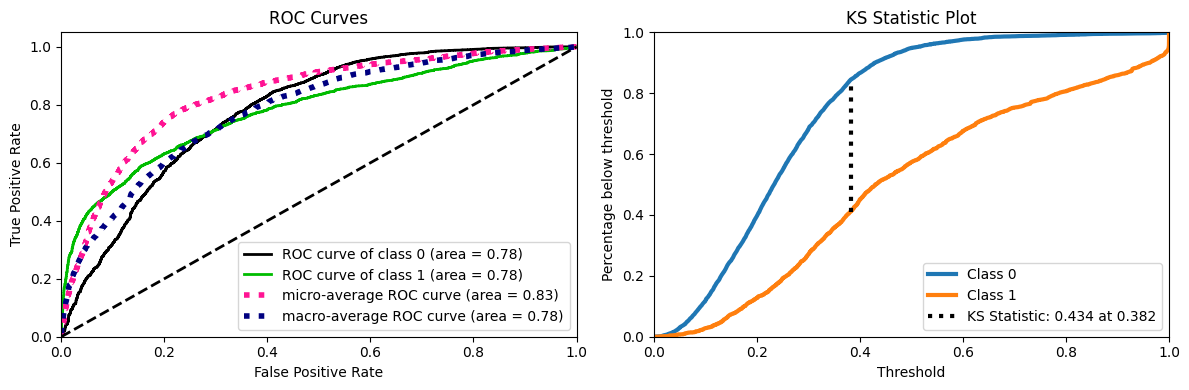

In [293]:
# Prediction
yhat = model.predict_proba(x_train)

# Save info
save_roc_auc_score.append(['train', roc_auc_score(y_train, yhat[:, 1])])

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
## AUC ROC
ax = axes[0]
mt.plot_roc(y_train, yhat, ax=ax)
## KS Statistic
ax = axes[1]
mt.plot_ks_statistic(y_train, yhat, ax=ax)

plt.tight_layout()
plt.show()

### Base de teste

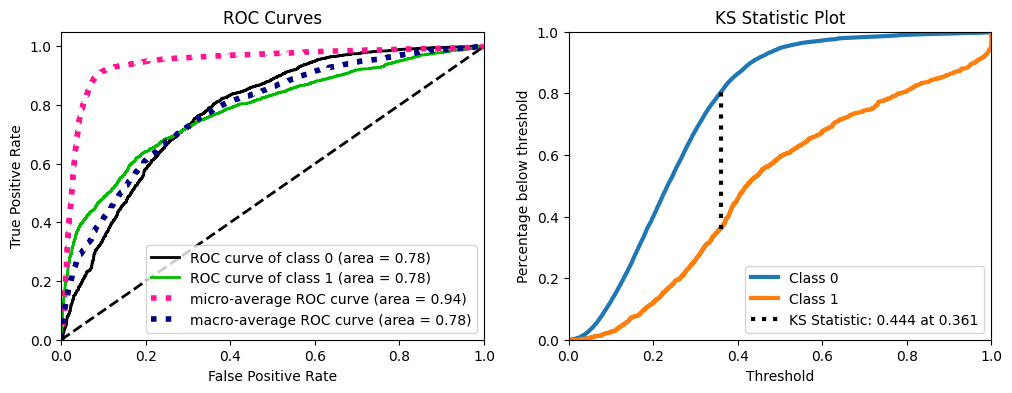

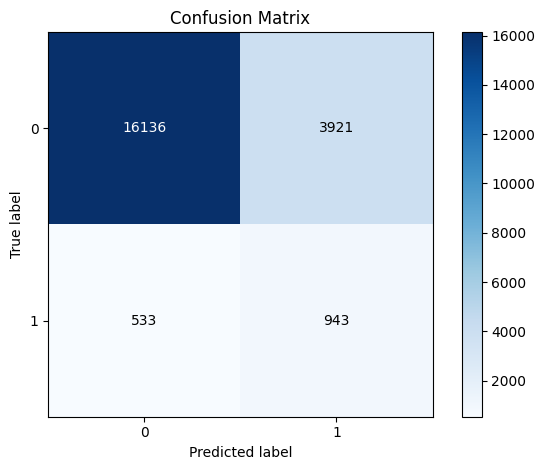

In [294]:
# Prediction
yhat = model.predict_proba(x_test)

# Save info
save_roc_auc_score.append(['test', roc_auc_score(y_test, yhat[:, 1])])

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
## AUC ROC
ax = axes[0]
mt.plot_roc(y_test, yhat, ax=ax)
## KS Statistic
ax = axes[1]
mt.plot_ks_statistic(y_test, yhat, ax=ax)
## Confusion Matrix
threshold = 0.361
yhat = (yhat[:, 1] >= threshold).astype(int)
mt.plot_confusion_matrix(y_test, yhat, normalize=False)

plt.tight_layout()
plt.show()

### Base Out of Time

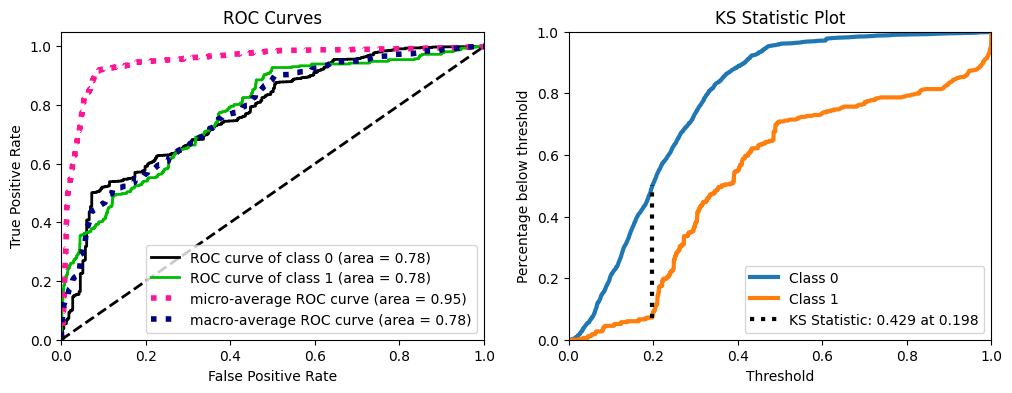

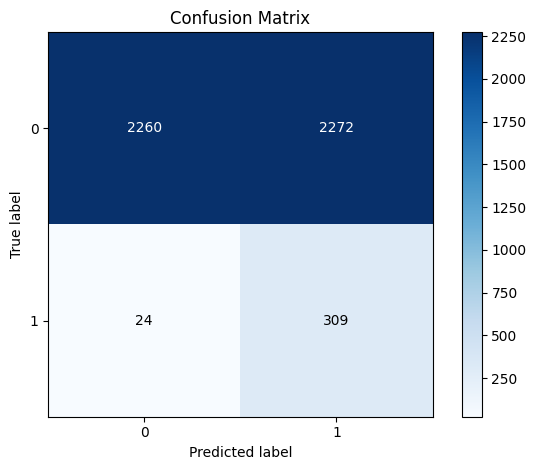

In [295]:
# Prediction
yhat = model.predict_proba(df_oot.drop('inadimplente', axis=1))

# Save info
save_roc_auc_score.append(['oot', roc_auc_score(df_oot.loc[:, 'inadimplente'], yhat[:, 1])])

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
## AUC ROC
ax = axes[0]
mt.plot_roc(df_oot.loc[:, 'inadimplente'], yhat, ax=ax)
## KS Statistic
ax = axes[1]
mt.plot_ks_statistic(df_oot.loc[:, 'inadimplente'], yhat, ax=ax)
## Confusion Matrix
threshold = 0.198
yhat = (yhat[:, 1] >= threshold).astype(int)
mt.plot_confusion_matrix(df_oot.loc[:, 'inadimplente'], yhat, normalize=False)

plt.tight_layout()
plt.show()

### Cross validation by Stratified KFold

In [296]:
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
scores = []

for train_index, val_index in skf.split(x_train, y_train):
    x_train_fold, x_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # AUC ROC score
    yhat = model.predict_proba(x_val_fold)
    scores.append(roc_auc_score(y_val_fold, yhat[:, 1]))

# Média das pontuações da cross validation
mean_score = sum(scores)/num_folds

# Save info
save_roc_auc_score.append(['cross_validation', mean_score])

# Print results
print("Pontuações de Validação Cruzada:", scores)
print("Média das Pontuações de Validação Cruzada:", mean_score)

Pontuações de Validação Cruzada: [0.7868317156143692, 0.7977620470646983, 0.7515587764191116, 0.7873893710301425, 0.7847180742458492]
Média das Pontuações de Validação Cruzada: 0.7816519968748341


### Resumo

Os valores de **ROC AUC score** são medianos, mas são valores **aceitáveis**.

In [297]:
machine_learning = '_logistic_reg'
df_roc_auc_score = pd.merge(df_roc_auc_score, pd.DataFrame(save_roc_auc_score, columns=['df', 'roc_auc_score_' + machine_learning]), how='left', on='df')
pd.DataFrame(save_roc_auc_score, columns=['df', 'roc_auc_score' + machine_learning])

,df,roc_auc_score_logistic_reg
0,train,0.782
1,test,0.783
2,oot,0.776
3,cross_validation,0.782


## 7.2 - Random Forest Classifier

In [298]:
# model definition
model = en.RandomForestClassifier(min_samples_leaf=300, n_jobs=-1, n_estimators=300, random_state=42)

# Fit
model.fit(x_train, y_train);

In [299]:
save_roc_auc_score = []

### Base de treino

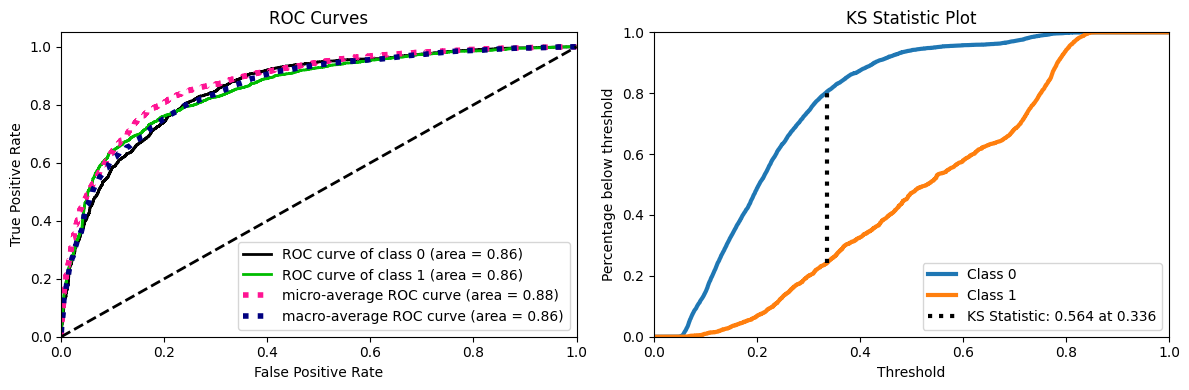

In [300]:
# Prediction
yhat = model.predict_proba(x_train)

# Save info
save_roc_auc_score.append(['train', roc_auc_score(y_train, yhat[:, 1])])

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
## AUC ROC
ax = axes[0]
mt.plot_roc(y_train, yhat, ax=ax)
## KS Statistic
ax = axes[1]
mt.plot_ks_statistic(y_train, yhat, ax=ax)

plt.tight_layout()
plt.show()

### Base de teste

Precision: 0.21
Recall: 0.75


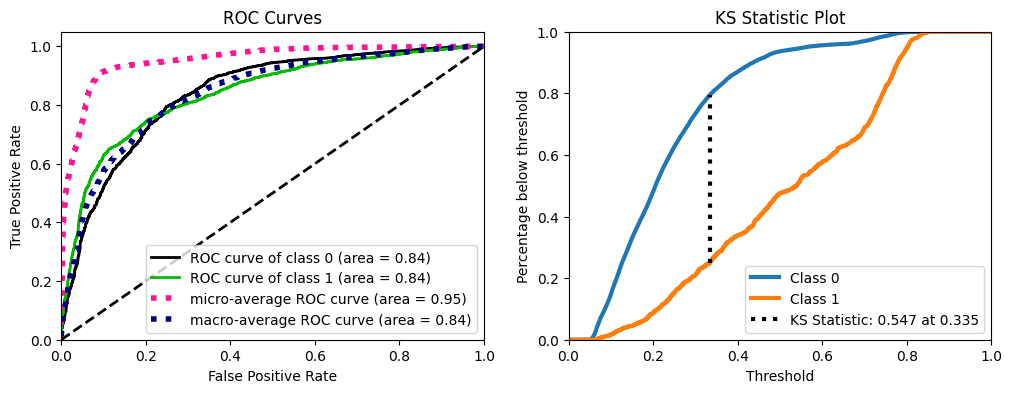

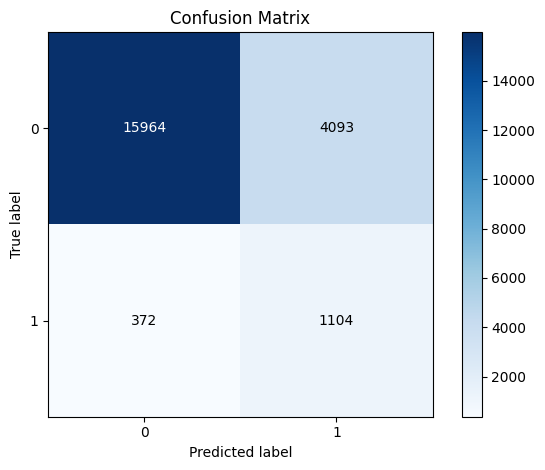

In [301]:
# Prediction
yhat = model.predict_proba(x_test)

# Save info
save_roc_auc_score.append(['test', roc_auc_score(y_test, yhat[:, 1])])



# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
## AUC ROC
ax = axes[0]
mt.plot_roc(y_test, yhat, ax=ax)
## KS Statistic
ax = axes[1]
mt.plot_ks_statistic(y_test, yhat, ax=ax)
## Confusion Matrix
threshold = 0.335
yhat = (yhat[:, 1] >= threshold).astype(int)
precision = precision_score(y_test, yhat)
recall = recall_score(y_test, yhat)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
mt.plot_confusion_matrix(y_test, yhat, normalize=False)

plt.tight_layout()
plt.show()

### Base Out of Time

Precision: 0.21
Recall: 0.82


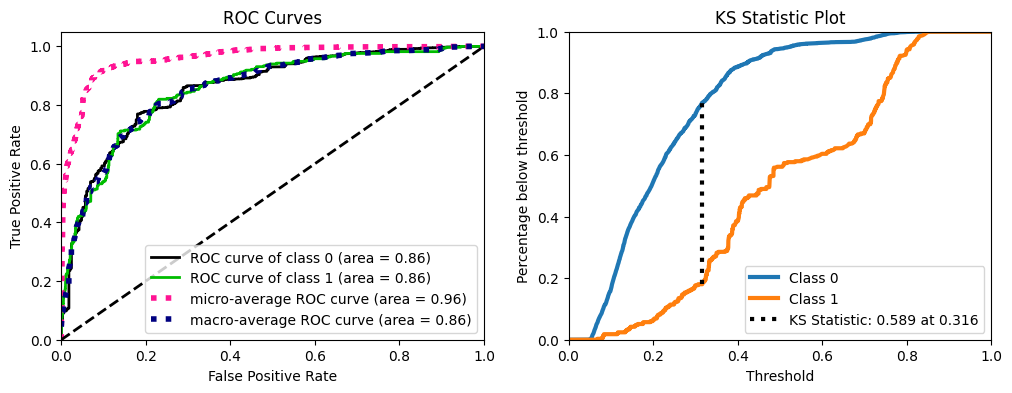

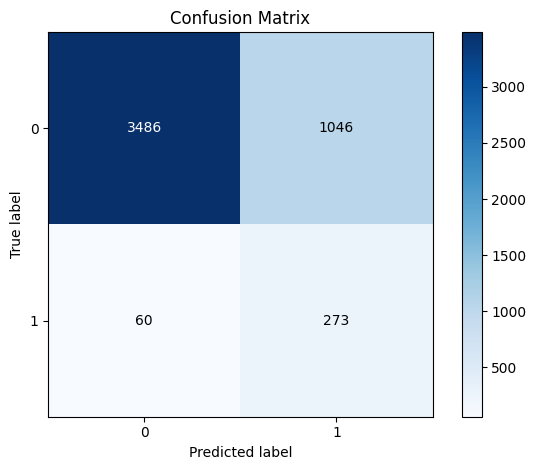

In [302]:
# Prediction
yhat = model.predict_proba(df_oot.drop('inadimplente', axis=1))

# Save info
save_roc_auc_score.append(['oot', roc_auc_score(df_oot.loc[:, 'inadimplente'], yhat[:, 1])])

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
## AUC ROC
ax = axes[0]
mt.plot_roc(df_oot.loc[:, 'inadimplente'], yhat, ax=ax)
## KS Statistic
ax = axes[1]
mt.plot_ks_statistic(df_oot.loc[:, 'inadimplente'], yhat, ax=ax)
## Confusion Matrix
threshold = 0.316
yhat = (yhat[:, 1] >= threshold).astype(int)
precision = precision_score(df_oot.loc[:, 'inadimplente'], yhat)
recall = recall_score(df_oot.loc[:, 'inadimplente'], yhat)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
mt.plot_confusion_matrix(df_oot.loc[:, 'inadimplente'], yhat, normalize=False)

plt.tight_layout()
plt.show()

### Cross validation by Stratified KFold

In [303]:
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
scores = []

for train_index, val_index in skf.split(x_train, y_train):
    x_train_fold, x_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # AUC ROC score
    yhat = model.predict_proba(x_val_fold)
    scores.append(roc_auc_score(y_val_fold, yhat[:, 1]))

# Média das pontuações da cross validation
mean_score = sum(scores)/num_folds

# Save info
save_roc_auc_score.append(['cross_validation', mean_score])

# Print results
print("Pontuações de Validação Cruzada:", scores)
print("Média das Pontuações de Validação Cruzada:", mean_score)

Pontuações de Validação Cruzada: [0.8548329679161075, 0.8688018866452357, 0.8343599835918271, 0.8654420864418757, 0.8652068717816583]
Média das Pontuações de Validação Cruzada: 0.8577287592753409


### Resumo

Os valores de **ROC AUC score** são maiores que os da Regressão Logística. São valores **aceitáveis**.

In [304]:
machine_learning = '_random_forest'
df_roc_auc_score = pd.merge(df_roc_auc_score, pd.DataFrame(save_roc_auc_score, columns=['df', 'roc_auc_score_' + machine_learning]), how='left', on='df')
pd.DataFrame(save_roc_auc_score, columns=['df', 'roc_auc_score' + machine_learning])

,df,roc_auc_score_random_forest
0,train,0.858
1,test,0.841
2,oot,0.856
3,cross_validation,0.858


## 7.3 - XGBoost Classifier

In [305]:
# model definition
model = xgb.XGBClassifier(booster='gbtree',
                          colsample_bytree=1,
                          max_depth=6, 
                          min_child_weight=1,
                          n_estimators=100, 
                          n_jobs=16,
                          random_state=0, 
                          subsample=1)

# Fit
model.fit(x_train, y_train);

In [306]:
save_roc_auc_score = []

### Base de treino

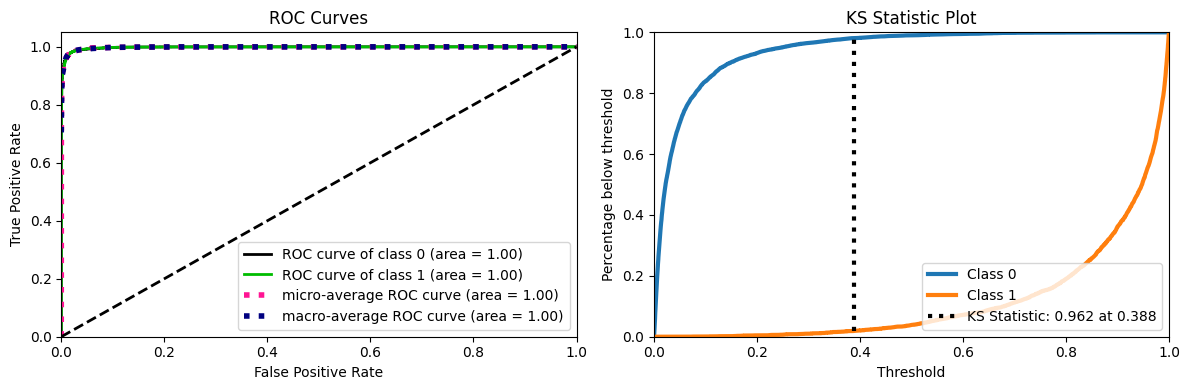

In [307]:
# Prediction
yhat = model.predict_proba(x_train)

# Save info
save_roc_auc_score.append(['train', roc_auc_score(y_train, yhat[:, 1])])

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
## AUC ROC
ax = axes[0]
mt.plot_roc(y_train, yhat, ax=ax)
## KS Statistic
ax = axes[1]
mt.plot_ks_statistic(y_train, yhat, ax=ax)
plt.tight_layout()
plt.show()

### Base de teste

Precision: 0.37
Recall: 0.89


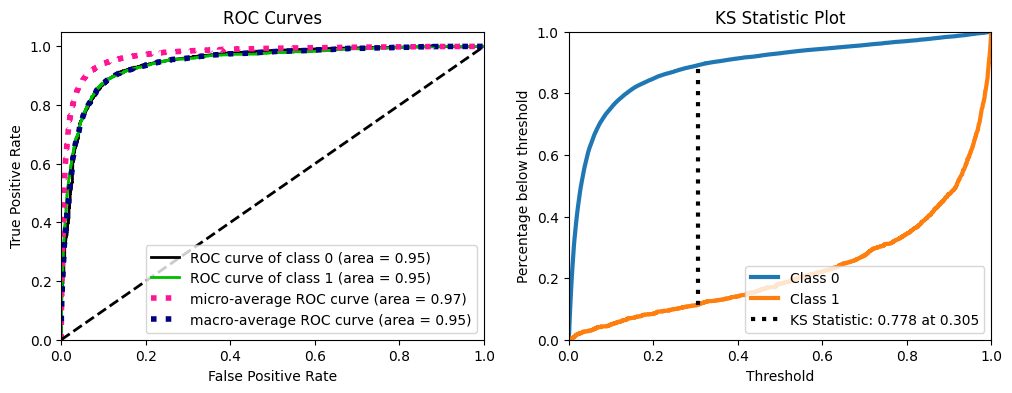

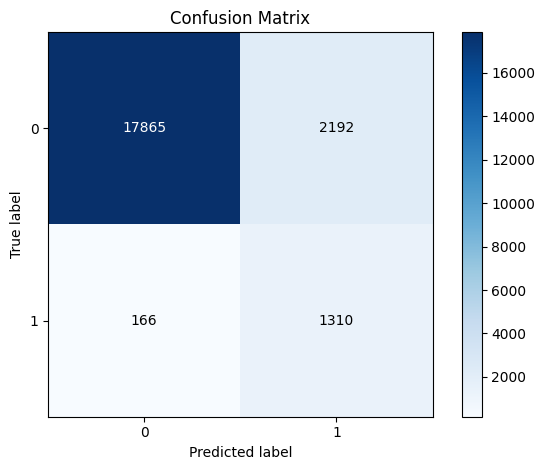

In [308]:
# Prediction
yhat = model.predict_proba(x_test)

# Save info
save_roc_auc_score.append(['test', roc_auc_score(y_test, yhat[:, 1])])

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
## AUC ROC
ax = axes[0]
mt.plot_roc(y_test, yhat, ax=ax)
## KS Statistic
ax = axes[1]
mt.plot_ks_statistic(y_test, yhat, ax=ax)
## Confusion Matrix
threshold = 0.305
yhat = (yhat[:, 1] >= threshold).astype(int)
precision = precision_score(y_test, yhat)
recall = recall_score(y_test, yhat)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
mt.plot_confusion_matrix(y_test, yhat, normalize=False)

plt.tight_layout()
plt.show()

### Base Out of Time

Precision: 0.36
Recall: 0.84


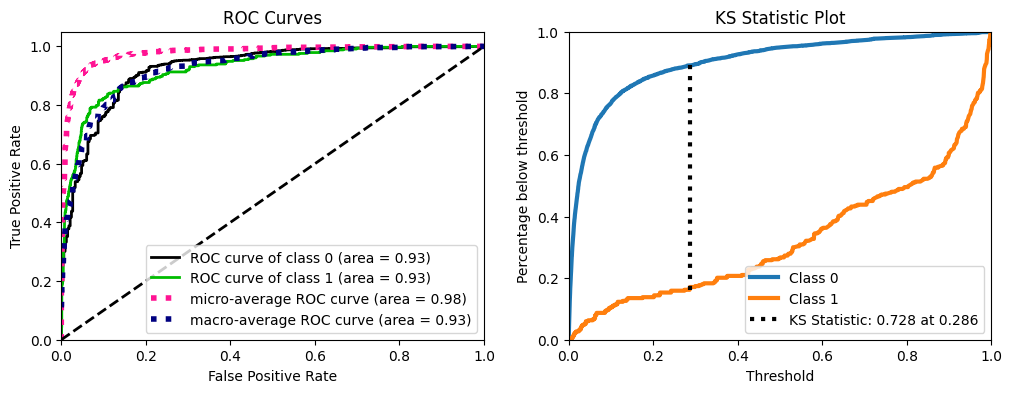

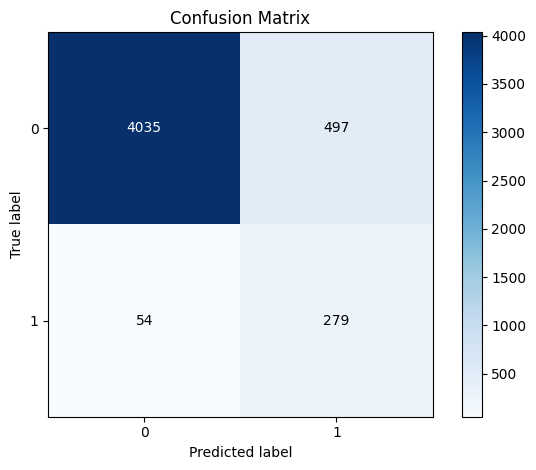

In [309]:
# Prediction
yhat = model.predict_proba(df_oot.drop('inadimplente', axis=1))

# Save info
save_roc_auc_score.append(['oot', roc_auc_score(df_oot.loc[:, 'inadimplente'], yhat[:, 1])])

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
## AUC ROC
ax = axes[0]
mt.plot_roc(df_oot.loc[:, 'inadimplente'], yhat, ax=ax)
## KS Statistic
ax = axes[1]
mt.plot_ks_statistic(df_oot.loc[:, 'inadimplente'], yhat, ax=ax)
## Confusion Matrix
threshold = 0.286
yhat = (yhat[:, 1] >= threshold).astype(int)
precision = precision_score(df_oot.loc[:, 'inadimplente'], yhat)
recall = recall_score(df_oot.loc[:, 'inadimplente'], yhat)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
mt.plot_confusion_matrix(df_oot.loc[:, 'inadimplente'], yhat, normalize=False)

plt.tight_layout()
plt.show()

### Cross validation by Stratified KFold

In [310]:
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
scores = []

for train_index, val_index in skf.split(x_train, y_train):
    x_train_fold, x_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # AUC ROC score
    yhat = model.predict_proba(x_val_fold)
    scores.append(roc_auc_score(y_val_fold, yhat[:, 1]))

# Média das pontuações da cross validation
mean_score = sum(scores)/num_folds

# Save info
save_roc_auc_score.append(['cross_validation', mean_score])

# Print results
print("Pontuações de Validação Cruzada:", scores)
print("Média das Pontuações de Validação Cruzada:", mean_score)

Pontuações de Validação Cruzada: [0.9979801270247496, 0.998064979245342, 0.998402156502715, 0.9986379997579533, 0.9981861143318929]
Média das Pontuações de Validação Cruzada: 0.9982542753725305


### Resumo

Os valores de **ROC AUC score** mostram diferenças significativas entre as bases de dados, mostrando uma certa tendência ao overfitting. Apesar disso, são valores **aceitáveis**.

In [311]:
machine_learning = '_xgboost_classifier'
df_roc_auc_score = pd.merge(df_roc_auc_score, pd.DataFrame(save_roc_auc_score, columns=['df', 'roc_auc_score_' + machine_learning]), how='left', on='df')
pd.DataFrame(save_roc_auc_score, columns=['df', 'roc_auc_score' + machine_learning])

,df,roc_auc_score_xgboost_classifier
0,train,0.998
1,test,0.946
2,oot,0.926
3,cross_validation,0.998


## 7.4 - LightGBM

In [318]:
# model definition
model = lgb.LGBMClassifier(verbosity=-1)

# Fit
model.fit(x_train, y_train);

In [319]:
save_roc_auc_score = []

### Base de treino

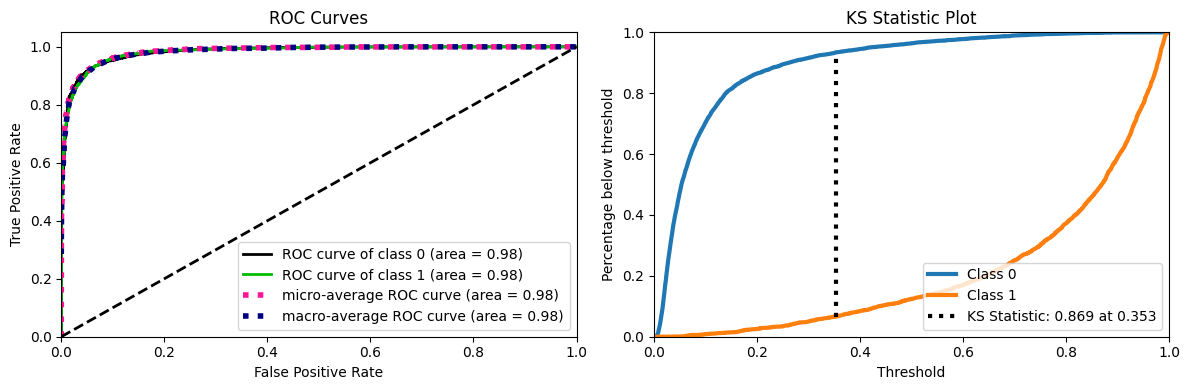

In [320]:
# Prediction
yhat = model.predict_proba(x_train)

# Save info
save_roc_auc_score.append(['train', roc_auc_score(y_train, yhat[:, 1])])

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
## AUC ROC
ax = axes[0]
mt.plot_roc(y_train, yhat, ax=ax)
## KS Statistic
ax = axes[1]
mt.plot_ks_statistic(y_train, yhat, ax=ax)

plt.tight_layout()
plt.show()

### Base de teste

Precision: 0.38
Recall: 0.87


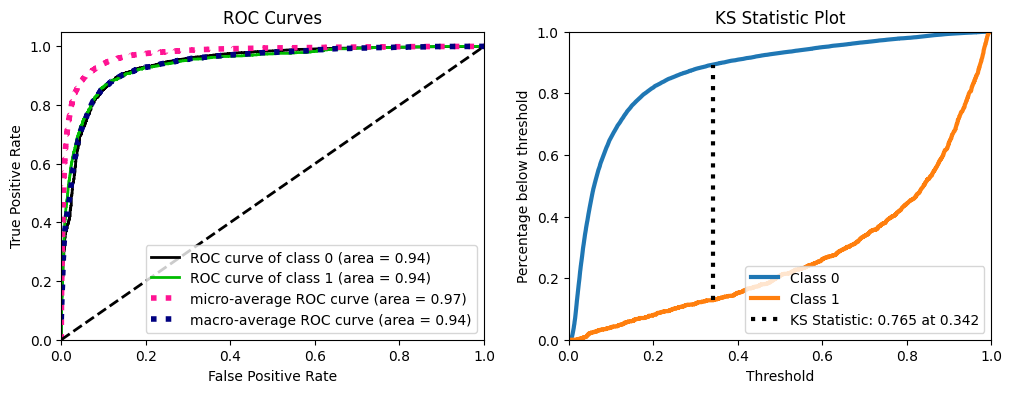

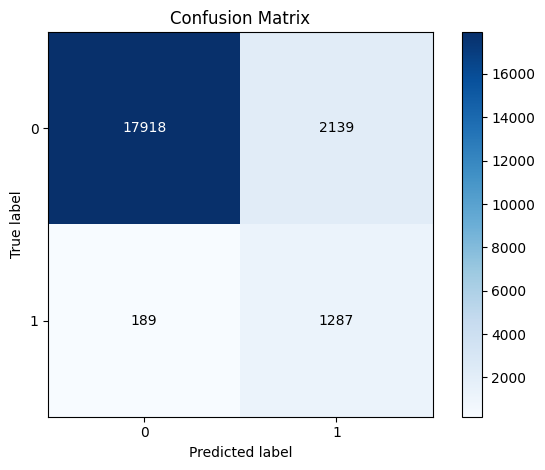

In [321]:
# Prediction
yhat = model.predict_proba(x_test)

# Save info
save_roc_auc_score.append(['test', roc_auc_score(y_test, yhat[:, 1])])

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
## AUC ROC
ax = axes[0]
mt.plot_roc(y_test, yhat, ax=ax)
## KS Statistic
ax = axes[1]
mt.plot_ks_statistic(y_test, yhat, ax=ax)
## Confusion Matrix
threshold = 0.342
yhat = (yhat[:, 1] >= threshold).astype(int)
precision = precision_score(y_test, yhat)
recall = recall_score(y_test, yhat)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
mt.plot_confusion_matrix(y_test, yhat, normalize=False)

plt.tight_layout()
plt.show()

### Base Out of Time

Precision: 0.39
Recall: 0.85


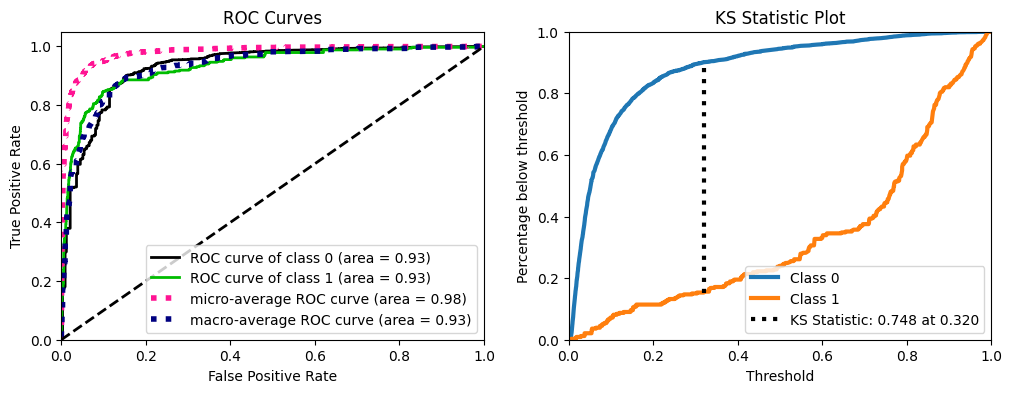

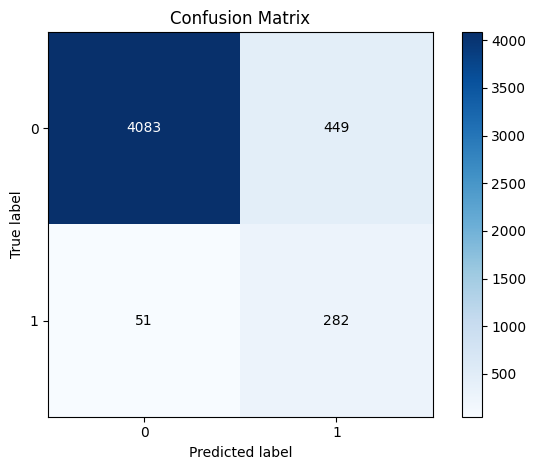

In [322]:
# Prediction
yhat = model.predict_proba(df_oot.drop('inadimplente', axis=1))

# Save info
save_roc_auc_score.append(['oot', roc_auc_score(df_oot.loc[:, 'inadimplente'], yhat[:, 1])])

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
## AUC ROC
ax = axes[0]
mt.plot_roc(df_oot.loc[:, 'inadimplente'], yhat, ax=ax)
## KS Statistic
ax = axes[1]
mt.plot_ks_statistic(df_oot.loc[:, 'inadimplente'], yhat, ax=ax)
## Confusion Matrix
threshold = 0.320
yhat = (yhat[:, 1] >= threshold).astype(int)
precision = precision_score(df_oot.loc[:, 'inadimplente'], yhat)
recall = recall_score(df_oot.loc[:, 'inadimplente'], yhat)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
mt.plot_confusion_matrix(df_oot.loc[:, 'inadimplente'], yhat, normalize=False)

plt.tight_layout()
plt.show()

### Cross validation by Stratified KFold

In [323]:
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
scores = []

for train_index, val_index in skf.split(x_train, y_train):
    x_train_fold, x_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # AUC ROC score
    yhat = model.predict_proba(x_val_fold)
    scores.append(roc_auc_score(y_val_fold, yhat[:, 1]))

# Média das pontuações da cross validation
mean_score = sum(scores)/num_folds

# Save info
save_roc_auc_score.append(['cross_validation', mean_score])

# Print results
print("Pontuações de Validação Cruzada:", scores)
print("Média das Pontuações de Validação Cruzada:", mean_score)

Pontuações de Validação Cruzada: [0.9802070004057302, 0.9852425408070908, 0.9803219127241474, 0.9850414212040649, 0.983441766315699]
Média das Pontuações de Validação Cruzada: 0.9828509282913466


### Resumo

Os valores de **ROC AUC score** mostram um leve tendência ao overfitting, menos exagerado o XGBoost. Apesar disso, são valores **aceitáveis**.

In [324]:
machine_learning = '_light_gbm'
df_roc_auc_score = pd.merge(df_roc_auc_score, pd.DataFrame(save_roc_auc_score, columns=['df', 'roc_auc_score_' + machine_learning]), how='left', on='df')
pd.DataFrame(save_roc_auc_score, columns=['df', 'roc_auc_score' + machine_learning])

,df,roc_auc_score_light_gbm
0,train,0.983
1,test,0.941
2,oot,0.931
3,cross_validation,0.983


## 7.5 - Comparativo dos resultados do modelos

In [111]:
# Adaptações do dataframe: Cálculo da média e desvio padrão dos valores de ROC AUC score
df_roc_auc_score = df_roc_auc_score.set_index('df')
mean_std = []

for i in list(df_roc_auc_score.columns):
    mean_std.append([df_roc_auc_score[i].mean(), df_roc_auc_score[i].std()])
    
mean_std = pd.DataFrame(mean_std, columns=['mean', 'std']).T
mean_std.columns = list(df_roc_auc_score.columns)

df_roc_auc_score = pd.concat([df_roc_auc_score, mean_std])
df_roc_auc_score

,roc_auc_score__logistic_reg,roc_auc_score__random_forest,roc_auc_score__xgboost_classifier,roc_auc_score__light_gbm
train,0.781714,0.857654,0.998238,0.982863
test,0.782794,0.841134,0.945722,0.941463
oot,0.775702,0.855586,0.926442,0.930574
cross_validation,0.781652,0.857729,0.998254,0.982851
mean,0.780465,0.853026,0.967164,0.959438
std,0.003219,0.007990,0.036743,0.027405


O modelo **LightGBM** possui o menor desvio padrão de **ROC AUC score** dentre os modelos, podendo ser entendido como uma **menor** tendência ao **overfitting**. O ótimo valor médio de ROC AUC score também conta pontos para que o LightGBM seja **escolhido** como modelo a ser utilizado para predição da inadimplência.

# 8 - HYPERPARAMETER FINE TUNING

**MODELO SELECIONADO:** LIGHTGBM CLASSIFIER

## 8.1 - Grid Search

In [325]:
param_grid = {
    'num_leaves': [10, 20, 31, 40, 50],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [20, 50, 100, 200, 300],
    'verbosity': [-1]
}

In [193]:
# Model
model = lgb.LGBMClassifier()

# ObjetoGridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=0)

# Pesquisa da grade de dados
grid_search.fit(x_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_

# Train model
best_model = lgb.LGBMClassifier(**best_params)
best_model.fit(x_train, y_train)

# Faça previsões com o modelo treinado
yhat = best_model.predict_proba(x_test)[:, 1]

# Avalie o desempenho do modelo com os melhores hiperparâmetros
roc_auc = roc_auc_score(y_test, yhat)

print(f'Melhores Hiperparâmetros: {best_params}')
print(f'AUC ROC com Melhores Hiperparâmetros: {roc_auc:.2f}')

Melhores Hiperparâmetros: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 50, 'verbosity': -1}
AUC ROC com Melhores Hiperparâmetros: 0.95


## 8.2 - Modelo treinado com os hiperparâmetros ótimos

In [334]:
model = lgb.LGBMClassifier(num_leaves=best_params['num_leaves'],
                           learning_rate=best_params['learning_rate'],
                           n_estimators=best_params['n_estimators'],
                           verbosity=-1,
                           random_state=42)

# Fit
model.fit(x_train, y_train);

In [335]:
save_roc_auc_score = []

### Base de treino

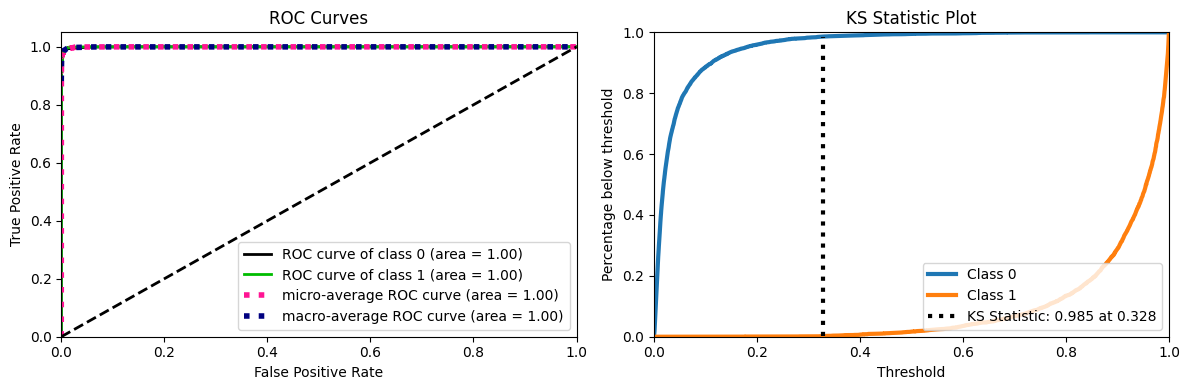

In [336]:
# Prediction
yhat = model.predict_proba(x_train)

# Save info
save_roc_auc_score.append(['train', roc_auc_score(y_train, yhat[:, 1])])

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
## AUC ROC
ax = axes[0]
mt.plot_roc(y_train, yhat, ax=ax)
## KS Statistic
ax = axes[1]
mt.plot_ks_statistic(y_train, yhat, ax=ax)
plt.tight_layout()
plt.show()

### Base de teste

Precision: 0.38
Recall: 0.89


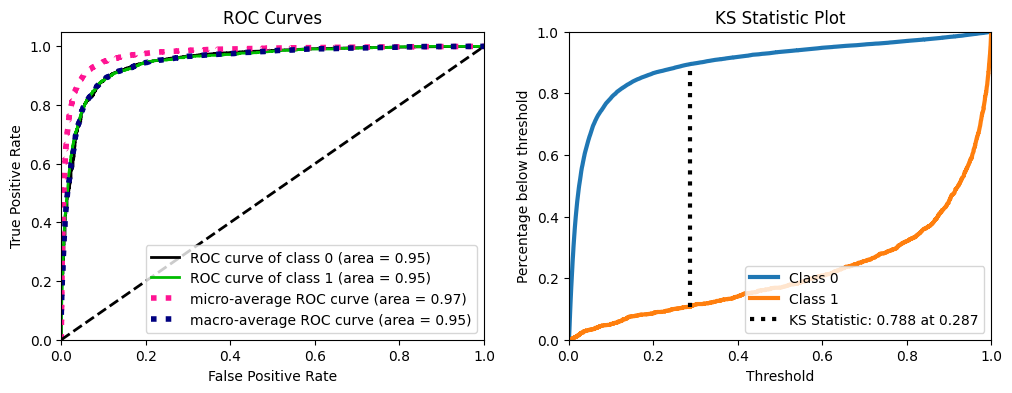

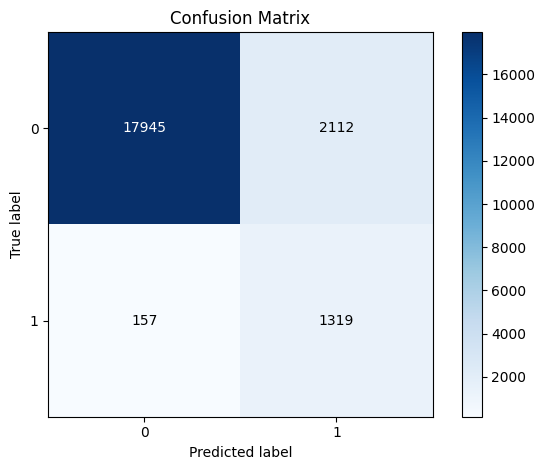

In [337]:
# Prediction
yhat = model.predict_proba(x_test)

# Save info
save_roc_auc_score.append(['test', roc_auc_score(y_test, yhat[:, 1])])

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
## AUC ROC
ax = axes[0]
mt.plot_roc(y_test, yhat, ax=ax)
## KS Statistic
ax = axes[1]
mt.plot_ks_statistic(y_test, yhat, ax=ax)
## Confusion Matrix
threshold = 0.287
yhat = (yhat[:, 1] >= threshold).astype(int)
precision = precision_score(y_test, yhat)
recall = recall_score(y_test, yhat)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
mt.plot_confusion_matrix(y_test, yhat, normalize=False)

plt.tight_layout()
plt.show()

### Base Out of Time

Precision: 0.39
Recall: 0.86


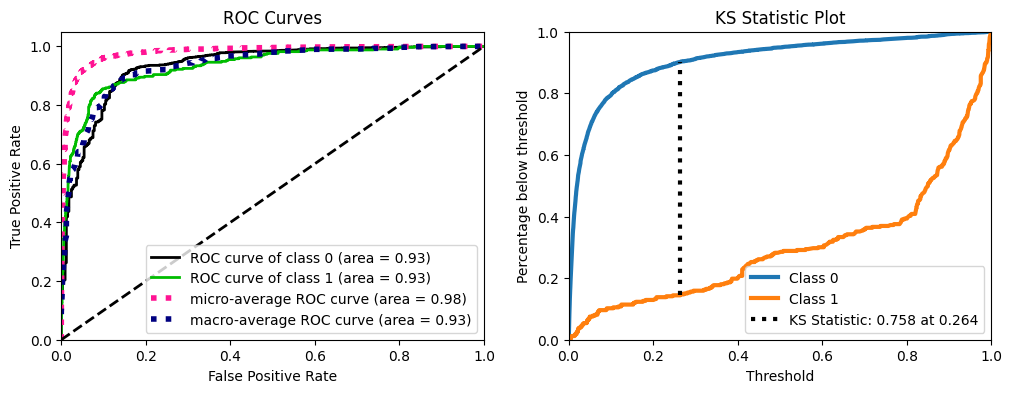

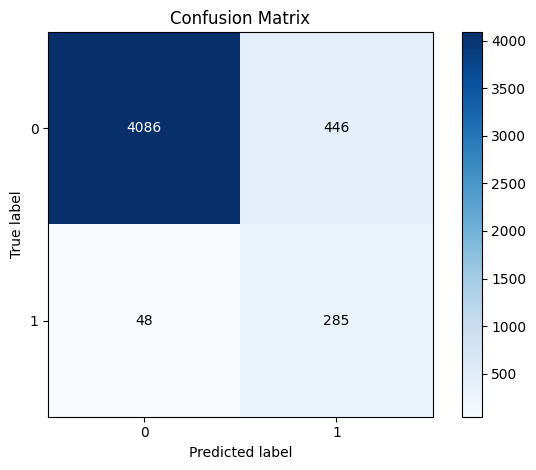

In [338]:
# Prediction
yhat = model.predict_proba(df_oot.drop('inadimplente', axis=1))

# Save info
save_roc_auc_score.append(['oot', roc_auc_score(df_oot.loc[:, 'inadimplente'], yhat[:, 1])])

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
## AUC ROC
ax = axes[0]
mt.plot_roc(df_oot.loc[:, 'inadimplente'], yhat, ax=ax)
## KS Statistic
ax = axes[1]
mt.plot_ks_statistic(df_oot.loc[:, 'inadimplente'], yhat, ax=ax)
## Confusion Matrix
threshold = 0.264
yhat = (yhat[:, 1] >= threshold).astype(int)
precision = precision_score(df_oot.loc[:, 'inadimplente'], yhat)
recall = recall_score(df_oot.loc[:, 'inadimplente'], yhat)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
mt.plot_confusion_matrix(df_oot.loc[:, 'inadimplente'], yhat, normalize=False)

plt.tight_layout()
plt.show()

### Cross validation by Stratified KFold

In [339]:
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
scores = []

for train_index, val_index in skf.split(x_train, y_train):
    x_train_fold, x_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # AUC ROC score
    yhat = model.predict_proba(x_val_fold)
    scores.append(roc_auc_score(y_val_fold, yhat[:, 1]))

# Média das pontuações da cross validation
mean_score = sum(scores)/num_folds

# Save info
save_roc_auc_score.append(['cross_validation', mean_score])

# Print results
print("Pontuações de Validação Cruzada:", scores)
print("Média das Pontuações de Validação Cruzada:", mean_score)

Pontuações de Validação Cruzada: [0.9995728129583971, 0.9996449861115445, 0.9997939211626363, 0.9997311135315774, 0.999599354282078]
Média das Pontuações de Validação Cruzada: 0.9996684376092467


### Resumo

Os valores de **ROC AUC score** mostram uma certa tendência ao overfitting. Apesar disso, são valores **aceitáveis**. Os valores de **Precision e Recall** variaram com baixa intensidade, tendo o Recall um valor mais alto. É importante que o Recall seja **alto**, pois o impacto do prejuízo deixado pela inadimplência será **mais reduzido**, já que a maioria das inadimplências serão detectadas. O **treshold do KS Statistic** fornece um valor próximo ao ótimo a ser considerado na predição do modelo, portanto este será usado.

In [340]:
machine_learning = '_light_gbm'
pd.DataFrame(save_roc_auc_score, columns=['df', 'roc_auc_score' + machine_learning])

,df,roc_auc_score_light_gbm
0,train,1.000
1,test,0.951
2,oot,0.934
3,cross_validation,1.000


# 9 - AVALIAÇÃO DO MODELO COM VISÃO DE NEGÓCIO

A avaliação será baseada na **comparação** entre o **lucro em %** obtido utilizando ou não o modelo. O lucro é calculado multiplicando-se a **taxa de juros** pelo **valor a ser pago** pelo cliente. Um problema nesta avaliação é que não se tem uma referência de dano causado pela inadimplência sobre as contas da empresa que fornece o serviço de crédito, portanto, vários cenários serão avaliados **variado-se a % média** do valor do empréstimo que a empresa perde com a inadimplência.

In [341]:
# % média do valor de empréstimo que a empresa perde para a inadimplência
cenarios = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

In [342]:
# Base de dados de avaliação: a mesma que 'Out of time'
aval = df_oot_save.loc[:, ['valor_a_pagar', 'taxa', 'inadimplente']]

# Predict e adaptação da predição ao threshold selecionado
yhat = model.predict_proba(df_oot.drop('inadimplente', axis=1))
threshold = 0.264
yhat = (yhat[:, 1] >= threshold).astype(int)

# Join do dataframe com as predições
aval = aval.reset_index(drop=True).join(pd.DataFrame(yhat))
aval = aval.rename(columns={0: 'predicao'})

# Criação da variável 'lucro'
aval['lucro'] = aval.loc[:, 'valor_a_pagar'] * aval.loc[:, 'taxa']/100

aval.head()

,valor_a_pagar,taxa,inadimplente,predicao,lucro
0,40195.010,5.990,0,1,2407.681
1,59932.500,5.990,0,1,3589.957
2,40192.000,5.990,0,1,2407.501
3,120225.000,5.990,0,1,7201.477
4,24628.200,4.990,0,0,1228.947


In [343]:
df_aval = pd.DataFrame()

for i in cenarios:
    porc_perda = i
    # Lucro se não acontecesse nenhuma perda para a inadimplência
    lucro_sem_perdas = np.round(aval.loc[:, 'lucro'].sum(), 2)
    
    #-------------------- Caso sem uso do modelo ------------------------#
    # Total perdido para a inadimplência
    total_perdido_sem_modelo = np.round(porc_perda * aval.loc[(aval['inadimplente']==1), 'valor_a_pagar'].sum(), 2)
    # Lucro descontando as perdas
    lucro_remanescente_sem_modelo = np.round(lucro_sem_perdas - total_perdido_sem_modelo, 2)
    porc_lucro_remanescente_sem_modelo = np.round(lucro_remanescente_sem_modelo/lucro_sem_perdas, 2)
    
    #-------------------- Caso com uso do modelo ------------------------#
    # Valor de emprestimo salvo pelo modelo após prever inadimplência
    valor_salvo_modelo = np.round(aval.loc[(aval['inadimplente']==1) & (aval['predicao']==1), 'valor_a_pagar'].sum(), 2)
    # Lucro perdido pela predição errada de inadimplência
    lucro_perdido = np.round(aval.loc[(aval['inadimplente']==0) & (aval['predicao']==1), 'lucro'].sum(), 2)
    # Valor perdido porque o modelo não foi capaz de prever a inadimplência
    valor_perdido_modelo = np.round(porc_perda * aval.loc[(aval['inadimplente']==1) & (aval['predicao']==0), 'valor_a_pagar'].sum(), 2)
    # Total perdido
    total_perdido_com_modelo = valor_perdido_modelo + lucro_perdido
    # Lucro descontando as perdas
    lucro_remanescente_com_modelo = np.round(lucro_sem_perdas - total_perdido_com_modelo, 2)
    porc_lucro_remanescente_com_modelo = np.round(lucro_remanescente_com_modelo/lucro_sem_perdas, 2)
    
    # Aumento do lucro
    aumento_lucro = lucro_remanescente_com_modelo/lucro_remanescente_sem_modelo - 1
    
    # Dataframe de resultados
    aux = pd.DataFrame({'porc_perda': [porc_perda],
                        'lucro_sem_perdas': [lucro_sem_perdas],
                        'valor_salvo_modelo': [valor_salvo_modelo],
                        
                        'total_perdido_sem_modelo': [total_perdido_sem_modelo],
                        'total_perdido_com_modelo': [total_perdido_com_modelo],
                        
                        'lucro_remanescente_sem_modelo': [lucro_remanescente_sem_modelo],
                        'lucro_remanescente_com_modelo': [lucro_remanescente_com_modelo],
                        
                        'porc_lucro_remanescente_sem_modelo': [porc_lucro_remanescente_sem_modelo],                   
                        'porc_lucro_remanescente_com_modelo': [porc_lucro_remanescente_com_modelo],
                        
                        'porc_aumento_lucro': [aumento_lucro]
                       })
    df_aval = pd.concat([df_aval, aux])

df_aval = df_aval.set_index('porc_perda').T
df_aval

porc_perda,0.200,0.300,0.400,0.500,0.600,0.700,0.800
lucro_sem_perdas,18280979.250,18280979.250,18280979.250,18280979.250,18280979.250,18280979.250,18280979.250
valor_salvo_modelo,8667363.090,8667363.090,8667363.090,8667363.090,8667363.090,8667363.090,8667363.090
total_perdido_sem_modelo,2157585.360,3236378.040,4315170.720,5393963.400,6472756.090,7551548.770,8630341.450
total_perdido_com_modelo,1294908.630,1506965.010,1719021.380,1931077.750,2143134.120,2355190.490,2567246.870
lucro_remanescente_sem_modelo,16123393.890,15044601.210,13965808.530,12887015.850,11808223.160,10729430.480,9650637.800
lucro_remanescente_com_modelo,16986070.620,16774014.240,16561957.870,16349901.500,16137845.130,15925788.760,15713732.380
porc_lucro_remanescente_sem_modelo,0.880,0.820,0.760,0.700,0.650,0.590,0.530
porc_lucro_remanescente_com_modelo,0.930,0.920,0.910,0.890,0.880,0.870,0.860
porc_aumento_lucro,0.054,0.115,0.186,0.269,0.367,0.484,0.628


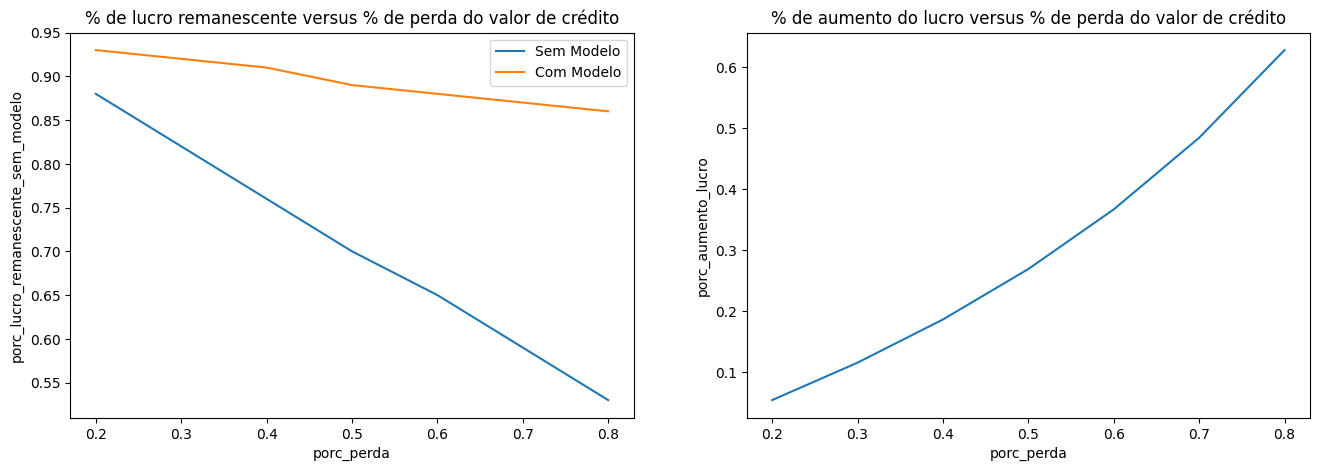

In [191]:
plt.figure(figsize=[16, 5])
plt.subplot(1, 2, 1)
sns.lineplot(x='porc_perda', y='porc_lucro_remanescente_sem_modelo', data=df_aval.T.reset_index(), label='Sem Modelo')
sns.lineplot(x='porc_perda', y='porc_lucro_remanescente_com_modelo', data=df_aval.T.reset_index(), label='Com Modelo')
plt.title('% de lucro remanescente versus % de perda do valor de crédito')
plt.legend()

plt.subplot(1, 2, 2)
sns.lineplot(x='porc_perda', y='porc_aumento_lucro', data=df_aval.T.reset_index())
plt.title('% de aumento do lucro versus % de perda do valor de crédito');

**OBSERVAÇÃO**

A avaliação acima mostra que o uso do modelo apresenta uma **situação favorável** em qualquer um dos cenários apresentados. À medida que se **perde** mais do valor de crédito, o modelo é capaz de **segurar bem** o prejuízo com a inadimplência. É bem provável que a porcentagem média de perda do valor de crédito seja alta, **entre 50 e 70%**. Isso significa que modelo é capaz de **manter o lucro remanescente** (após as deduções das perdas) entre **87% e 89%** enquanto que a ausência do modelo mantém entre **59% e 70%**. Além disso o modelo aumenta entre **26,9% a 48,4%** o lucro quando comparado à ausência do modelo.